# Проект: классификация

In [1]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

import plotly.express as px
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

import warnings
warnings.filterwarnings('ignore')

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [3]:
df = pd.read_csv('data/bank_fin.zip', sep=';')

Данные о клиентах банка:
* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды);
* balance (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:
* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).

Прочие признаки:
* campaign (количество контактов с этим клиентом в течение текущей кампании)
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании)
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании)
* deposit наша целевая переменная, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [5]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,"1,00 $",yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,"733,00 $",no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,"29,00 $",no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0 $,no,yes,cellular,8,may,9,2,172,5,failure,no


In [6]:
count_null = df.isnull().sum()
count_null[count_null > 0]

balance    25
dtype: int64

Явные пропущенные значения лишь в столбце balance, 25 записей 

### Задание 2

In [7]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

В признаке job категория unknown это как-раз пропущенные значения

In [8]:
df.describe(include='object')

,job,marital,education,default,balance,housing,loan,contact,month,poutcome,deposit
count,11162,11162,11162,11162,11137,11162,11162,11162,11162,11162,11162
unique,12,3,4,2,3802,2,2,3,12,4,2
top,management,married,secondary,no,0 $,no,no,cellular,may,unknown,no
freq,2566,6351,5476,10994,774,5881,9702,8042,2824,8326,5873


In [9]:
df.describe()

,age,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


### Задание 3

Обратите внимание на признак balance: в данных содержится лишняя запятая и знак доллара. По этой причине этот признак не считывается как число. Обработайте данные этого признака так, чтобы он был преобразован в тип float.

In [10]:
df['balance'].value_counts()

0  $            774
 1,00 $          39
 3,00 $          34
 2,00 $          34
 4,00 $          29
               ... 
 1 641,00 $       1
 5 517,00 $       1
 8 332,00 $       1
 4 859,00 $       1
-134,00 $         1
Name: balance, Length: 3802, dtype: int64

In [11]:
# Удаляю пробелы, знак доллара и разделитель целой и дробной части с запятой меняю на точку, преобразую столбец к числовому типу
df['balance'] = df['balance'].str.replace(' ', '').str.replace('$', '').str.replace(',', '.').astype('float')

In [12]:
# После преобразований в балансе есть NaN
df[df['balance'].isnull()]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
9,28,services,single,secondary,no,NaN,yes,no,unknown,6,may,1297,3,-1,0,unknown,yes
2859,47,management,married,tertiary,no,NaN,no,no,cellular,29,oct,424,2,213,3,success,yes
2860,30,technician,single,secondary,no,NaN,no,no,cellular,29,oct,279,1,148,1,failure,yes
2888,67,retired,married,primary,no,NaN,no,no,cellular,6,nov,455,2,84,2,other,yes
2889,24,technician,married,secondary,no,NaN,yes,no,cellular,6,nov,368,2,80,2,success,yes
5356,45,blue-collar,married,primary,no,NaN,no,no,cellular,18,aug,230,8,-1,0,unknown,no
5357,40,blue-collar,married,secondary,no,NaN,yes,no,unknown,29,may,218,2,-1,0,unknown,no
5358,41,blue-collar,married,primary,no,NaN,yes,no,cellular,21,nov,888,3,-1,0,unknown,no
5359,35,management,single,tertiary,no,NaN,yes,yes,cellular,6,feb,217,1,-1,0,unknown,no
5360,62,retired,married,tertiary,no,NaN,yes,no,cellular,15,oct,73,1,-1,0,unknown,no


Задание 2.3

Вычислите среднее значение по преобразованному в корректный вид признаку balance. Ответ округлите до трёх знаков после точки-разделителя.

In [13]:
df['balance'].mean().round(3)

1529.129

### Задание 4

In [14]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'].fillna(df['balance'].median(), inplace=True)

Задание 2.4

Вычислите среднее значение по преобразованному в корректный вид признаку balance. Ответ округлите до трёх знаков после точки-разделителя.

In [15]:
df['balance'].mean().round(3)

1526.936

In [16]:
# Я бы еще конвертировал значения в целочисленные, ля данного признака это излишняя точность
# df['balance'] = df['balance'].round(0).astype('int')

### Задание 5

Ранее мы выяснили, что в признаке job есть пропущенные значения, которые не отображаются как пропуски в явном виде. Однако нам всё равно важно их обработать. Мы знаем, что для категориальных признаков пропущенные значения заменяются модой по данному признаку.

Замените все пропущенные значения в признаке job на модальные. То же самое сделайте с признаком, отвечающим за уровень образования.

In [17]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
to_processing = ['job', 'education']

for feature in to_processing:
  df[feature].replace('unknown', df[feature].mode()[0], inplace=True)

Задание 2.5

После замены пропусков рассчитайте средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование). Ответ округлите до трёх знаков после точки-разделителя.

In [18]:
top_job = df['job'].mode()[0]
top_education = df['education'].mode()[0]

mask = (df['job'] == top_job) & (df['education'] == top_education)

df[mask]['balance'].mean().round(3)

1598.883

### Задание 6

Изучите признак, отображающий баланс клиентов, на предмет выбросов.

В математической статистике есть несколько подходов, позволяющих определить наличие выбросов.

Используем метод Тьюки.

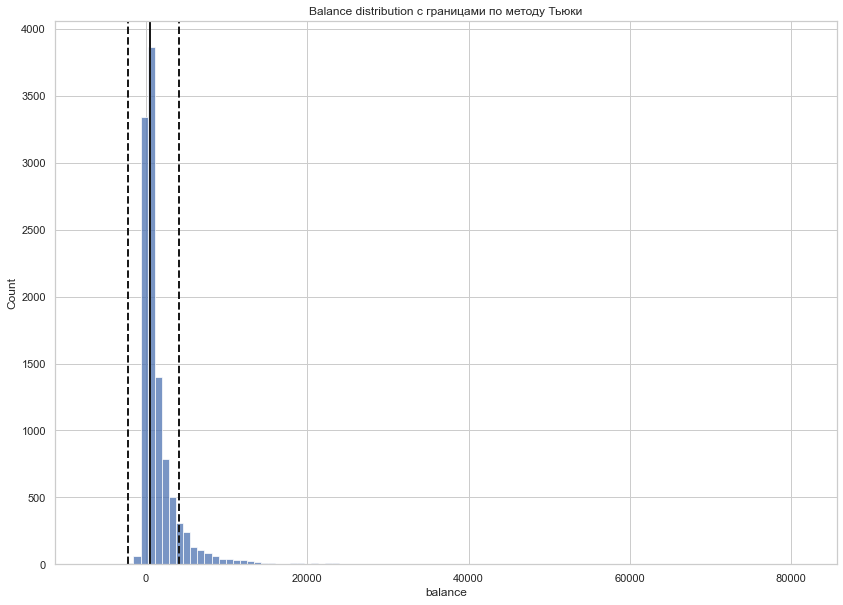

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
histplot = sns.histplot(data=df, x='balance', bins=100, ax=ax)

x = df['balance']
left = 1.5
right = 1.5

quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
iqr = quartile_3 - quartile_1

lower_bound = quartile_1 - (iqr * left)
upper_bound = quartile_3 + (iqr * right)

histplot.axvline(x.quantile(), color='k', lw=2)
histplot.axvline(lower_bound, color='k', ls='--', lw=2)
histplot.axvline(upper_bound, color='k', ls='--', lw=2)
histplot.set_title('Balance distribution c границами по методу Тьюки');

Распределение выглядит как нормальное с бОльшим выбросом в правую сторону.

In [20]:
df['balance'].describe()

count    11162.000000
mean      1526.936033
std       3224.829691
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1699.000000
max      81204.000000
Name: balance, dtype: float64

Нижняя и верхняя граница выбросов по методу Тьюки

In [21]:
import Handlers as hd

In [22]:
hd.outliers_iqr(df, 'balance')[1]

(-2241.0, 4063.0)

In [23]:
# удалите все выбросы для признака balance
df = hd.outliers_iqr(df, 'balance')[3]
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no


## Часть 2: Разведывательный анализ

### Задание 1

In [24]:
df['deposit'].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

In [25]:
df['deposit'].value_counts(normalize=True) * 100

no     53.676398
yes    46.323602
Name: deposit, dtype: float64

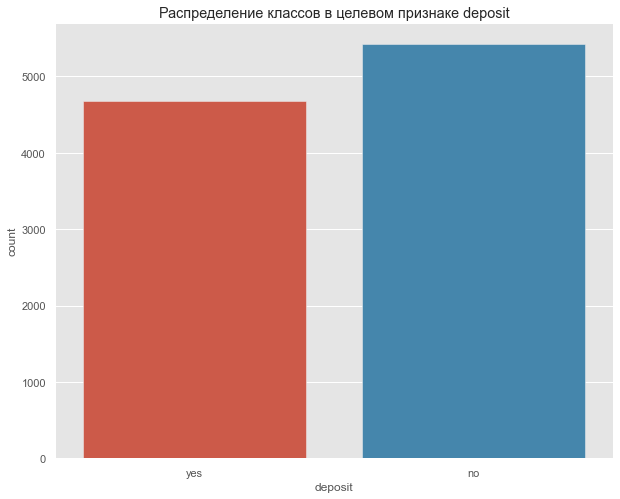

In [26]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
fig = plt.figure(figsize=(10, 8))
sns.countplot(data=df, x='deposit')
plt.title('Распределение классов в целевом признаке deposit')
plt.show()

Класс можно считать достаточно сбалансированным, но я все-равно использовал бы статифицированное разбиение

### Задания 2 и 3

In [27]:
# рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


* age - максимальный возраст 95 лет, вполне возможно, на явный выброс не похоже. Но после 70-80 лет это явно хвост.
за счет длинного хвоста справа средний возраст больше медианного значения. 40 против 38.
* balance - после удаления выбросов по методу Тьюки распределение стало напоминать нормальное. Но есть выбросы в виде отрицательных балансов, особенно -1000 отрицательные балансы это прям редкость.
* 


* previous - логнормальное распределение, но очень длинный правый хвост. И по сути признак нужно трансформировать в бинарный. Был ли контакт до этого - 1 или контакта не было 0. На всей выборке контакта не было для 75% клиентов и для оставшихся 25% было от 1 до 58 контактов, но думаю этот разброс абсолютно не важен.

In [28]:
num_columns = df.select_dtypes(include=[np.number]).columns.to_list()
num_columns

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

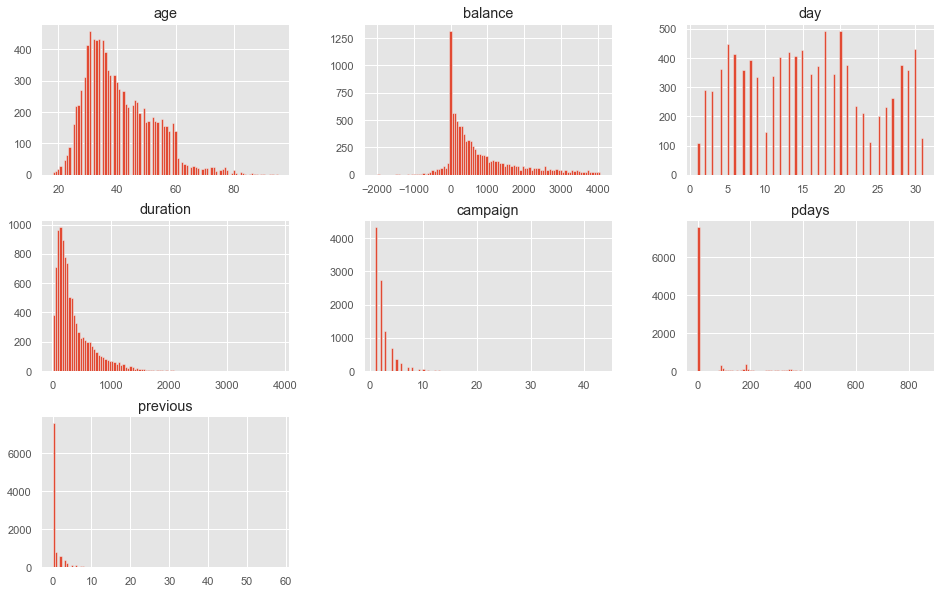

In [29]:
# Распределение по всем числовым признакам
df[num_columns].hist(figsize=(16, 10), bins=100);

<Figure size 1152x864 with 0 Axes>

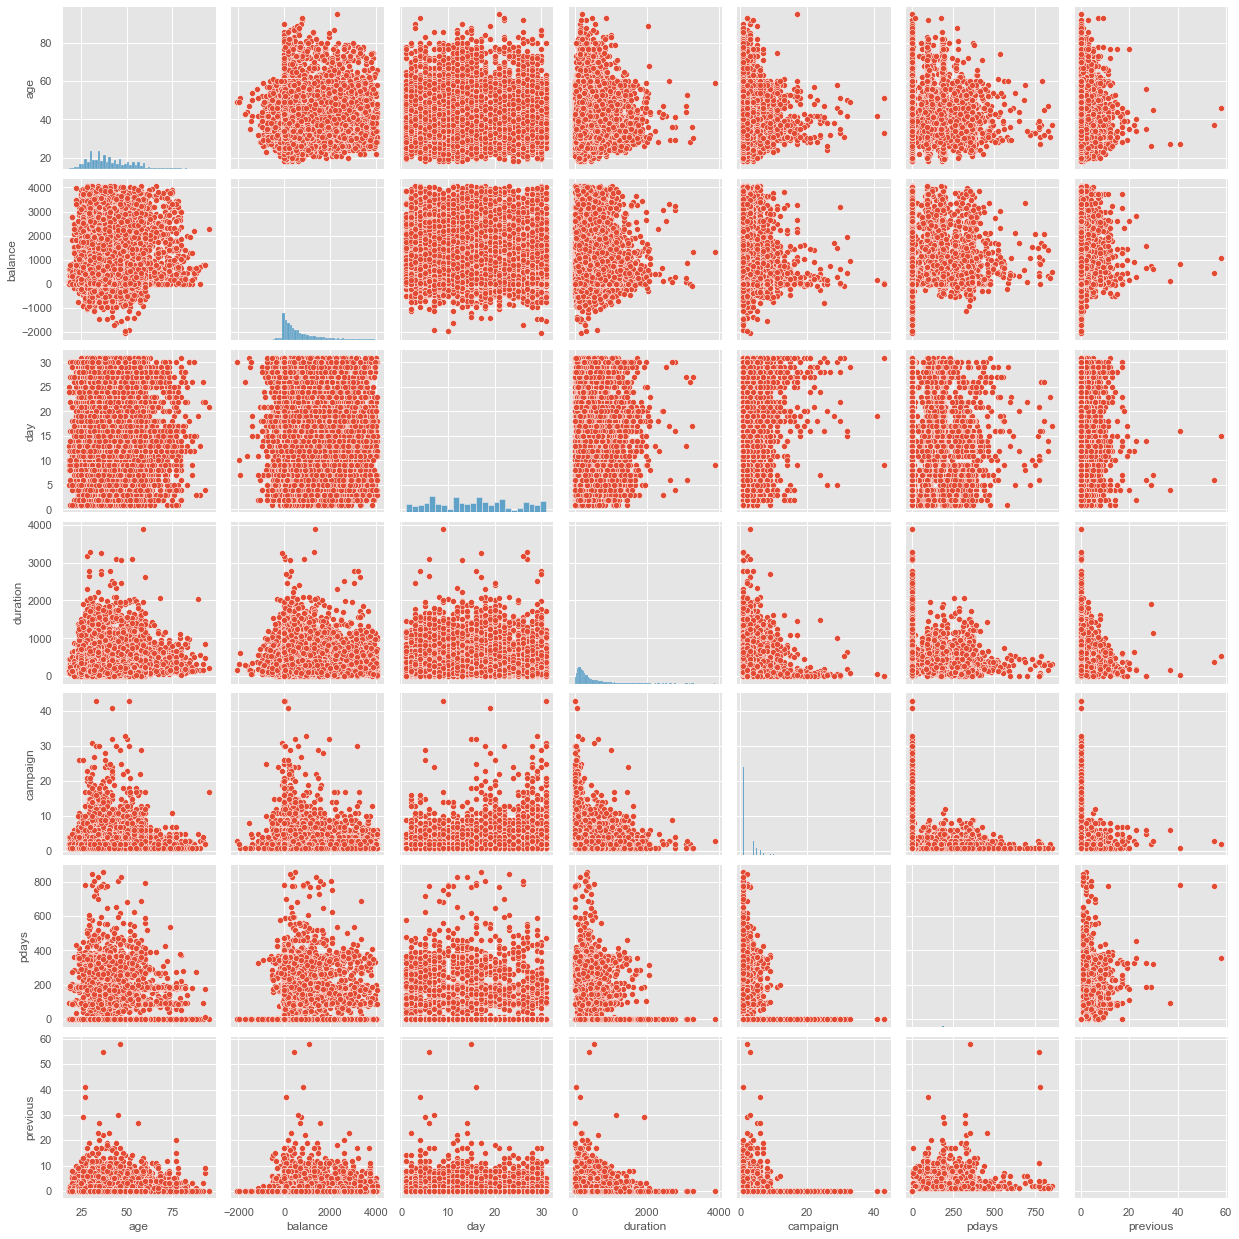

In [30]:
fig = plt.figure(figsize=(16, 12))
sns.pairplot(data=df)
plt.show()

Посмотрим на корреляции для числовых признаков

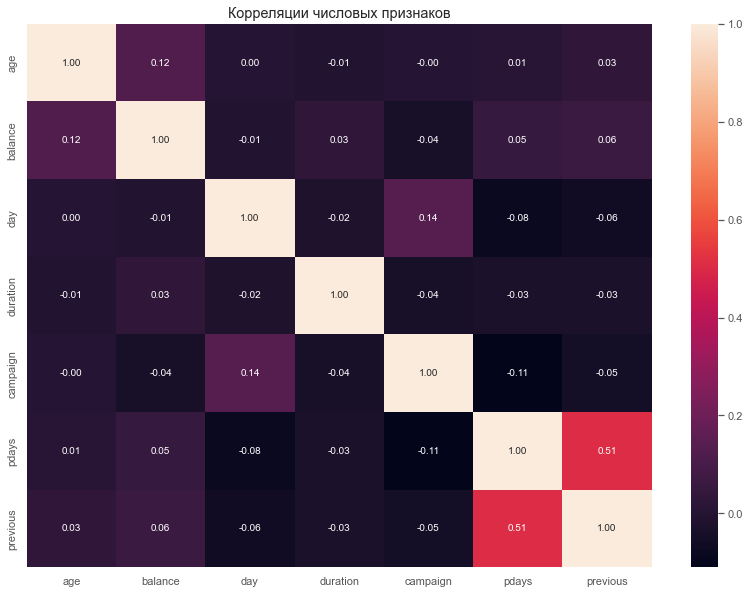

In [31]:
corr = df[num_columns].corr().round(2)
fig = plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.title('Корреляции числовых признаков')
plt.show()

Сильных корреляционых связей между числовыми признаками не обнаружено. Мультиколлинеарность исключена.

### Признак age

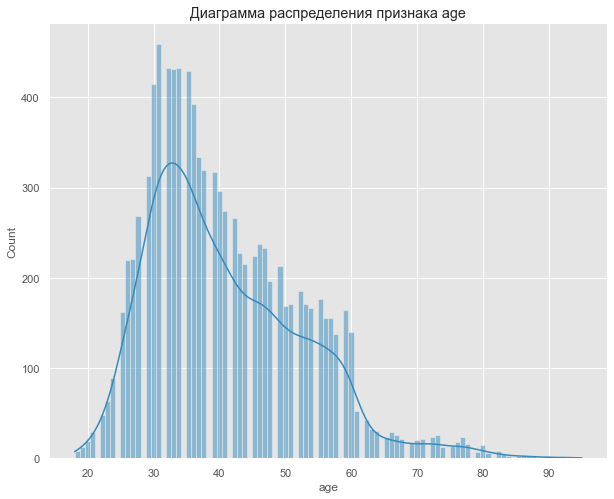

In [32]:
fig = plt.figure(figsize=(10, 8))
histplot = sns.histplot(data=df, x='age', bins=100, kde='mean')
histplot.set_title('Диаграмма распределения признака age')
plt.show()

Интересный провал (падение частотности) для возраста больше 60 лет. Длинный правый хвост.

In [33]:
df['age'].describe()

count    10105.000000
mean        40.895497
std         11.734931
min         18.000000
25%         32.000000
50%         38.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64

Cреднее выше медианы на 2 года, за счет длинного правого хвоста

In [34]:
fig = px.box(
  data_frame=df,
  x='age',
  color='deposit',
  height=500,
  width=800,
  title='Распределение возраста в зависимости от класса целевого признака deposit')

fig.update_layout(margin=dict(l=10, r=10, t=40, b=0))
fig.show()

Коробка возрастов для тех кто не открывает депозициты и разброс по усам уже чем у тех кто открывает депозиты.
Т.е. не открывает депозиты какая-то более узкая группа клиентов по возрасту.
Но при этом эта группа лежит внутри той, что открыла депозиты.
Медианный возраст открывших депозиты чуть ниже чем у не открывших.

### Признак balance

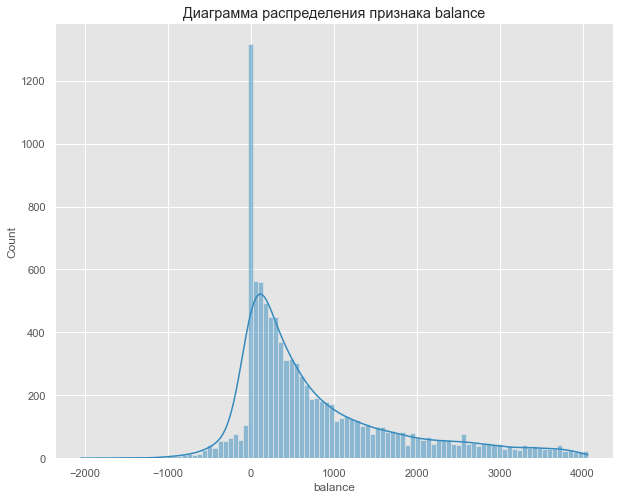

In [35]:
fig = plt.figure(figsize=(10, 8))
histplot = sns.histplot(data=df, x='balance', bins=100, kde='mean')
histplot.set_title('Диаграмма распределения признака balance')
plt.show()

Признак был бы похож на логнормальный, но тут есть счета с отрицательным балансом

In [36]:
df['balance'].describe()

count    10105.000000
mean       807.653538
std        994.151966
min      -2049.000000
25%         95.000000
50%        445.000000
75%       1227.000000
max       4063.000000
Name: balance, dtype: float64

In [37]:
fig = px.box(
  data_frame=df,
  x='balance',
  color='deposit',
  height=500,
  width=800,
  title='Распределение balance в зависимости от класса целевого признака deposit')

fig.update_layout(margin=dict(l=10, r=10, t=40, b=0))
fig.show()

Видно что те кто открывает депозиты имеют на счету больше денег, медианный баланс 569 против 342

Посмотрю отдельно % открытия депозитов для клиентов с положительным и отрицательным балансом

In [38]:
df[df['balance'] < 0]['deposit'].value_counts(normalize=True)

no     0.693548
yes    0.306452
Name: deposit, dtype: float64

In [39]:
df[df['balance'] >= 0]['deposit'].value_counts(normalize=True)

no     0.525417
yes    0.474583
Name: deposit, dtype: float64

Видно что % открывших депозит для у клиентов на счетах которых отрицательный баланс сильно ниже чем у тех, чьи счета в плюсе

30% против 47%

### Признак day

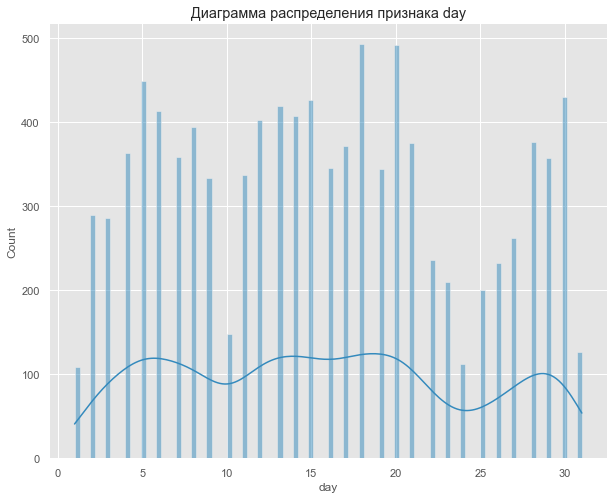

In [40]:
fig = plt.figure(figsize=(10, 8))
histplot = sns.histplot(data=df, x='day', bins=100, kde='mean')
histplot.set_title('Диаграмма распределения признака day')
plt.show()

In [41]:
df['day'].describe()

count    10105.000000
mean        15.590302
std          8.441510
min          1.000000
25%          8.000000
50%         15.000000
75%         22.000000
max         31.000000
Name: day, dtype: float64

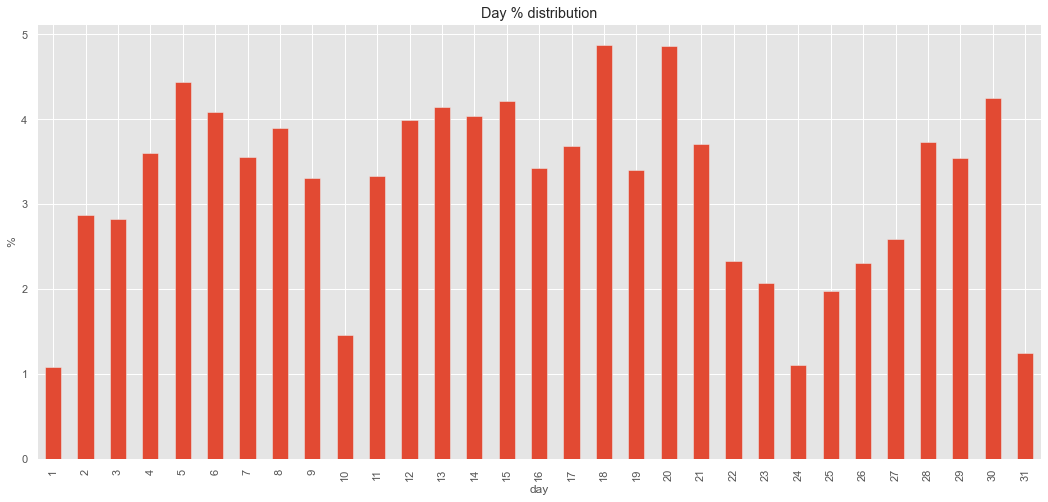

In [42]:
fig = plt.figure(figsize=(18, 8))
fig = (df['day'].value_counts(normalize=True).sort_index() * 100).plot.bar()
fig.set_xlabel('day')
fig.set_ylabel('%')
fig.set_title('Day % distribution')
plt.show()

Активность обзвона по дням месяца рисует спады в начале и конце месяца, а так же 10го и 24 числа.

In [43]:
fig = px.box(
  data_frame=df,
  x='day',
  color='deposit',
  height=500,
  width=800,
  title='Распределение дней обзвона в зависимости от класса целевого признака deposit')

fig.update_layout(margin=dict(l=10, r=10, t=40, b=0))
fig.show()

Видно что немного отличаются медианы дня месяца в разрезе классов целевого признака, был ли открыт депозит или нет

In [44]:
first_half_mask = df['day'] < 16
df[first_half_mask]['deposit'].value_counts(normalize=True)

no     0.504184
yes    0.495816
Name: deposit, dtype: float64

In [45]:
df[~first_half_mask]['deposit'].value_counts(normalize=True)

no     0.570479
yes    0.429521
Name: deposit, dtype: float64

Видно что во второй половине месяца депозиты открывают немного хуже.

### Признак duration

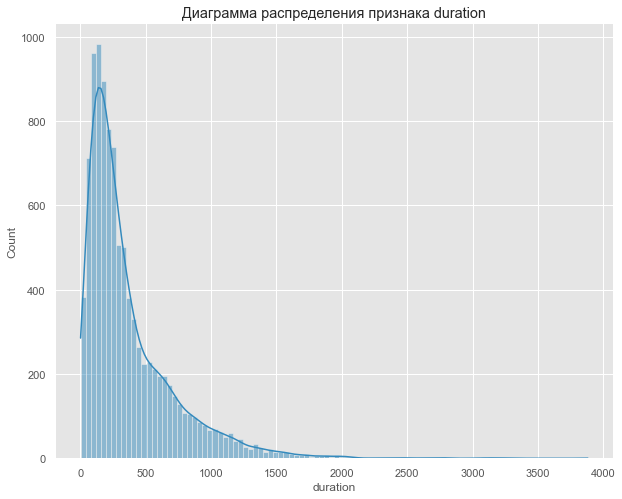

In [46]:
fig = plt.figure(figsize=(10, 8))
histplot = sns.histplot(data=df, x='duration', bins=100, kde='mean')
histplot.set_title('Диаграмма распределения признака duration')
plt.show()

In [47]:
df['duration'].describe()

count    10105.000000
mean       368.742603
std        346.651524
min          2.000000
25%        137.000000
50%        252.000000
75%        490.000000
max       3881.000000
Name: duration, dtype: float64

Есть выбросы в продолжительности разговора, макс значение 3881сек это 64мин, больше часа на телефоне с одним клиентом!
Думаю продолжительность разговоров должна укладываться в 10-20мин, не больше.

In [48]:
# Разговоры дольше 50мин
df[df['duration'] > 3000]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
153,44,services,divorced,secondary,no,51.0,yes,yes,unknown,27,may,3094,2,-1,0,unknown,yes
271,59,management,married,secondary,no,1321.0,no,no,unknown,9,jun,3881,3,-1,0,unknown,yes
358,28,admin.,single,secondary,no,-7.0,no,yes,unknown,26,jun,3183,2,-1,0,unknown,yes
883,36,self-employed,single,tertiary,no,-103.0,yes,yes,telephone,17,oct,3253,1,-1,0,unknown,yes
1351,47,blue-collar,married,secondary,no,238.0,yes,yes,cellular,13,mar,3076,1,-1,0,unknown,yes
4364,53,admin.,married,secondary,no,849.0,yes,no,cellular,6,feb,3102,3,-1,0,unknown,yes
7198,30,admin.,married,secondary,no,1310.0,no,no,telephone,27,oct,3284,1,-1,0,unknown,no


In [49]:
fig = px.box(
  data_frame=df,
  x='duration',
  color='deposit',
  height=500,
  width=900,
  title='Распределение продолжительности разговора (duration) в зависимости от класса целевого признака deposit')

fig.update_layout(margin=dict(l=10, r=10, t=40, b=0))
fig.show()

Коробка с усами времени разговора тех кто открыл депозит почти не пересекается с теми, кто депозит не открыл.

In [50]:
duration_mask = df['duration'] > 429

In [51]:
df[duration_mask]['deposit'].value_counts(normalize=True)

yes    0.799179
no     0.200821
Name: deposit, dtype: float64

In [52]:
df[~duration_mask]['deposit'].value_counts(normalize=True)

no     0.673489
yes    0.326511
Name: deposit, dtype: float64

Есть идея упростить сгенерировать новый признак, категориальный:
- до 30 сек - супер короткий разговор, фактически бросил трубку.
- от 30 до 90 - выслушал и не захотел продолжать.
- от 90 до 240 - выслушал, позадавал вопросы, но продолжать разговор не стал
- от 240 - длинный разговор с уточнением

Так же вариант конвертировать время разговора в минуты с отбрасыванием дробной части. 0.5мин это 0.

In [53]:
duration_min = (df['duration'] / 60).astype(int)

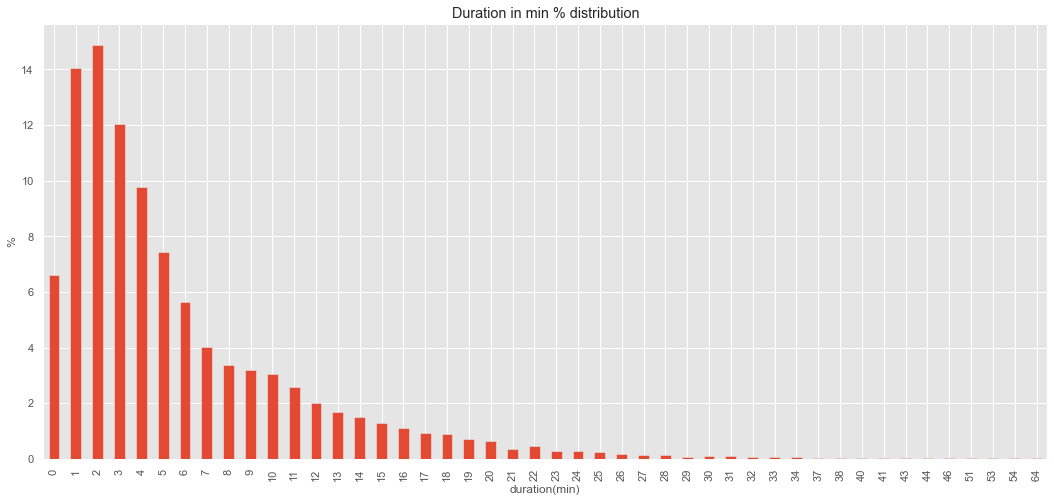

In [54]:
fig = plt.figure(figsize=(18, 8))
fig = (duration_min.value_counts(True).sort_index() * 100).plot.bar()
fig.set_xlabel('duration(min)')
fig.set_ylabel('%')
fig.set_title('Duration in min % distribution')
plt.show()

In [55]:
df['duration(min)'] = duration_min

In [56]:
fig = px.box(
  data_frame=df,
  x='duration(min)',
  color='deposit',
  height=500,
  width=900,
  title='Распределение продолжительности разговора (duration) в зависимости от класса целевого признака deposit')

fig.update_layout(margin=dict(l=10, r=10, t=40, b=0))
fig.show()

Коробки вообще не пересекаются теперь. Граница 4 мин.

In [57]:
# В проекте не используется, поэтому удаляю ранее созданный признак
df.drop(columns='duration(min)', inplace=True)

### Признак campaign
количество контактов с этим клиентом в течение текущей кампании

In [58]:
df['campaign'].describe()

count    10105.000000
mean         2.517170
std          2.707159
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         43.000000
Name: campaign, dtype: float64

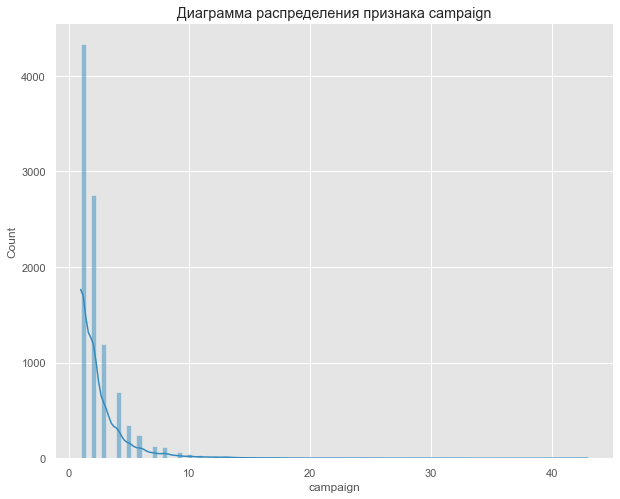

In [59]:
fig = plt.figure(figsize=(10, 8))
histplot = sns.histplot(data=df, x='campaign', bins=100, kde='mean')
histplot.set_title('Диаграмма распределения признака campaign')
plt.show()

Логнормальный признак, пробую логарифмировать

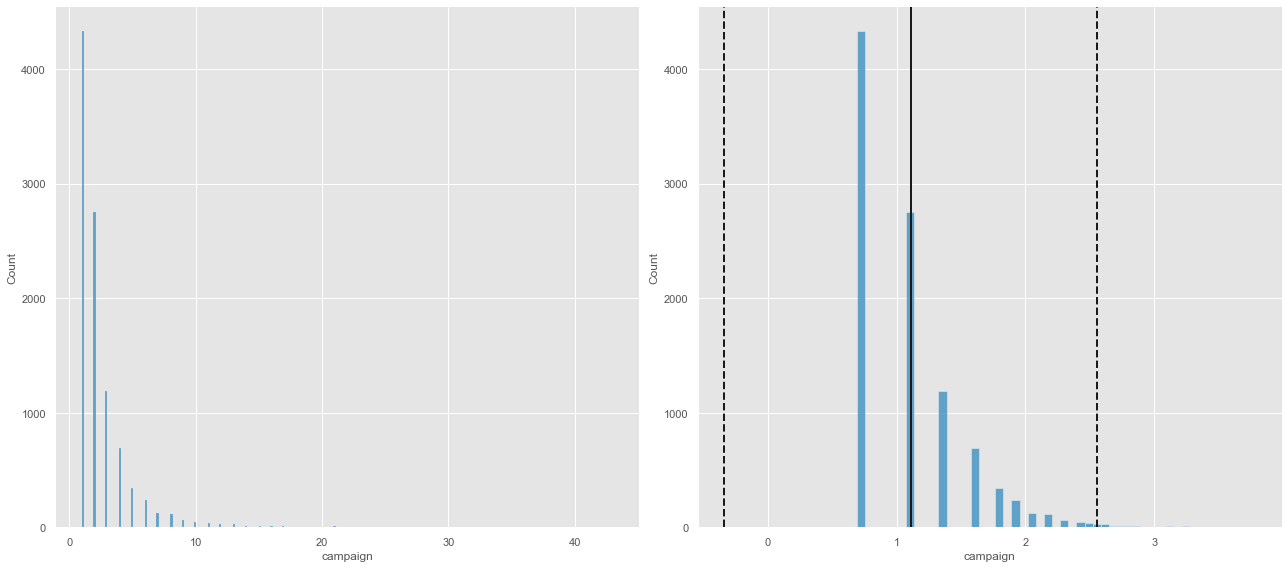

In [60]:
hd.plot_outliers_z_score(df, 'campaign', log_scale=True, left=3, right=3)

Как-то непомогло, нормального распределения я не увидел

In [61]:
fig = px.box(
  data_frame=df,
  x='campaign',
  color='deposit',
  height=500,
  width=900,
  title='Распределение количества контактов campaign в зависимости от класса целевого признака deposit')

fig.update_layout(margin=dict(l=10, r=10, t=40, b=0))
fig.show()

Для открывших депозит характерно меньшее количество контактов. Что-то типа того, что реально заинтересованный клиент сразу задает вопросы, уточняет и принимает решения. А те кто хочет что бы от них отстали могут просто тянуть время, предлагать перезвонить и т.д.

### Avg_duration генерирую признак средней длительности контакта с клиентом в сек

In [62]:
avg_duration = df['duration'] / df['campaign']

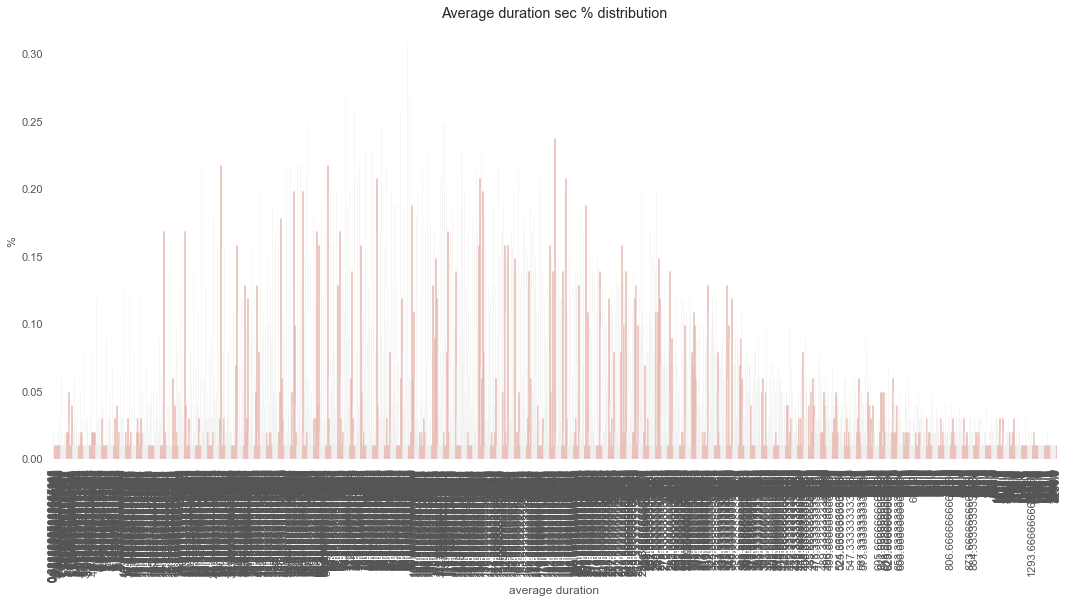

In [63]:
fig = plt.figure(figsize=(18, 8))
fig = (avg_duration.value_counts(True).sort_index() * 100).plot.bar()
fig.set_xlabel('average duration')
fig.set_ylabel('%')
fig.set_title('Average duration sec % distribution')
plt.show()

In [64]:
avg_duration.describe()

count    10105.000000
mean       233.595688
std        258.626389
min          0.266667
25%         66.500000
50%        151.000000
75%        303.000000
max       3284.000000
dtype: float64

In [65]:
df['avg_duration'] = avg_duration

In [66]:
fig = px.box(
  data_frame=df,
  x='avg_duration',
  color='deposit',
  height=500,
  width=900,
  title='Распределение средней продолжительности контакта в зависимости от класса целевого признака deposit')

fig.update_layout(margin=dict(l=10, r=10, t=40, b=0))
fig.show()

In [67]:
# Удаляю сгененрированный признак для сходимости результатов
df.drop(columns='avg_duration', inplace=True)

### Признак pdays 
количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании

In [68]:
df['pdays'].describe()

count    10105.000000
mean        51.319644
std        109.644179
min         -1.000000
25%         -1.000000
50%         -1.000000
75%          2.000000
max        854.000000
Name: pdays, dtype: float64

не понимаю что значит -1

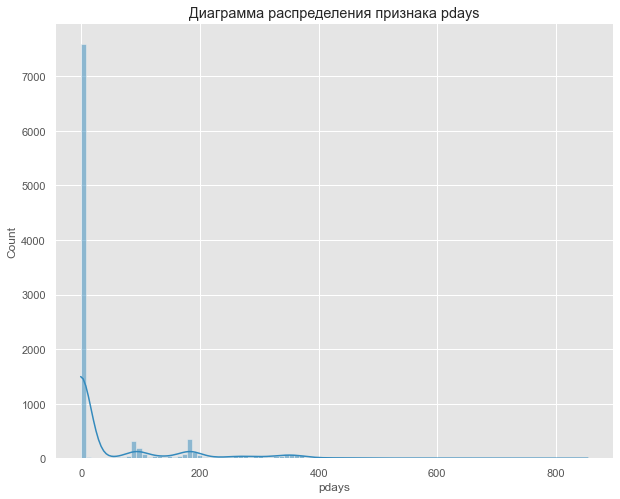

In [69]:
fig = plt.figure(figsize=(10, 8))
histplot = sns.histplot(data=df, x='pdays', bins=100, kde='mean')
histplot.set_title('Диаграмма распределения признака pdays')
plt.show()

In [70]:
df['pdays'].value_counts(normalize=True) * 100

-1      74.893617
 92      0.870856
 182     0.761999
 181     0.742207
 91      0.732311
          ...    
 440     0.009896
 455     0.009896
 470     0.009896
 435     0.009896
 701     0.009896
Name: pdays, Length: 458, dtype: float64

Признак думаю нужно преобразовывать в категориальный вид. На -1 приходится 75% выборки.
-1 значит что не было контактов в предыдущей маркетинговой компании. А сколько там конкретно дней прошло это не важно.
Важно что клиент холодный и с ним контактов вообще не было или слегка теплый т.к. ранее был с ним контакт.

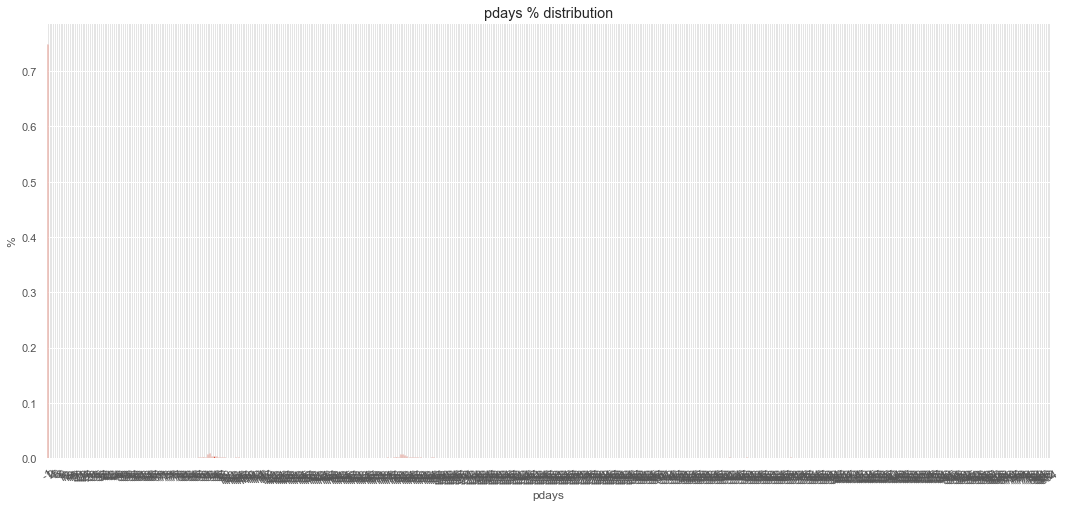

In [71]:
fig = plt.figure(figsize=(18, 8))
fig = (df['pdays'].value_counts(normalize=True).sort_index()).plot.bar()
fig.set_xlabel('pdays')
plt.xticks(rotation=30)
fig.set_ylabel('%')
fig.set_title('pdays % distribution')
plt.show()

In [72]:
df[df['pdays'] == -1]['deposit'].value_counts(True)

no     0.602801
yes    0.397199
Name: deposit, dtype: float64

In [73]:
df[df['pdays'] != -1]['deposit'].value_counts(True)

yes    0.660229
no     0.339771
Name: deposit, dtype: float64

Получается что при pdays=-1 очень мало открытий депозитов, всего 39%. А для pdays > -1 уже 66% открытия депозитов.

In [74]:
fig = px.box(
  data_frame=df,
  x='pdays',
  color='deposit',
  height=500,
  width=900,
  title='Распределение количества пропущенных дней pdays в зависимости от класса целевого признака deposit')

fig.update_layout(margin=dict(l=10, r=10, t=40, b=0))
fig.show()

Признак нужно будет пробовать конвертировать в категориальный бинарный. -1 = False, иначе True

In [75]:
df['was_previous_contact']  = df['pdays'].apply(lambda x: False if x == -1 else True)

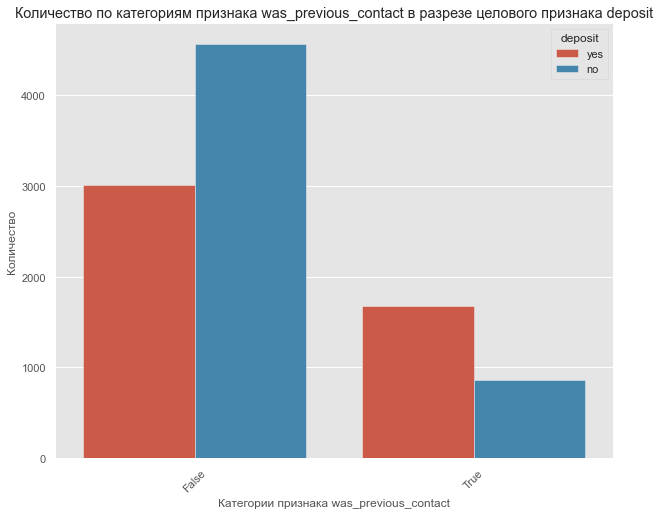

In [76]:
# Получаю список категорий отсортированных по убыванию доли во всей выборке
order_cat = df['was_previous_contact'].value_counts().index.to_list()

fig = plt.figure(figsize=(10, 8))
sns.countplot(data=df, x='was_previous_contact', hue='deposit', order=order_cat)
plt.title('Количество по категориям признака was_previous_contact в разрезе целового признака deposit')
plt.xticks(rotation=45)
plt.xlabel('Категории признака was_previous_contact')
plt.ylabel('Количество')
plt.show()

Новый бинарный признак хорошо показывает в разрезе признака был ли контакт в предыдущей компании (was_previous_contact) полностью меняется поведение клиентов. Если был контакт, то доля открывших депозит больше чем отказавшихся.

А если контакта ранее не было, то все наоборот.

In [77]:
# Для сходимости результатов сгененрированный признак удаляю
df.drop(columns='was_previous_contact', inplace=True)

### Признак previous
количество контактов до текущей кампании

In [78]:
df['previous'].describe()

count    10105.000000
mean         0.816230
std          2.243795
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         58.000000
Name: previous, dtype: float64

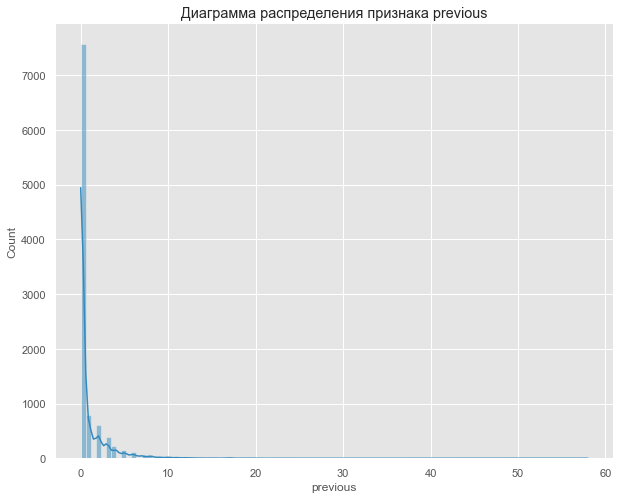

In [79]:
fig = plt.figure(figsize=(10, 8))
histplot = sns.histplot(data=df, x='previous', bins=100, kde='mean')
histplot.set_title('Диаграмма распределения признака previous')
plt.show()

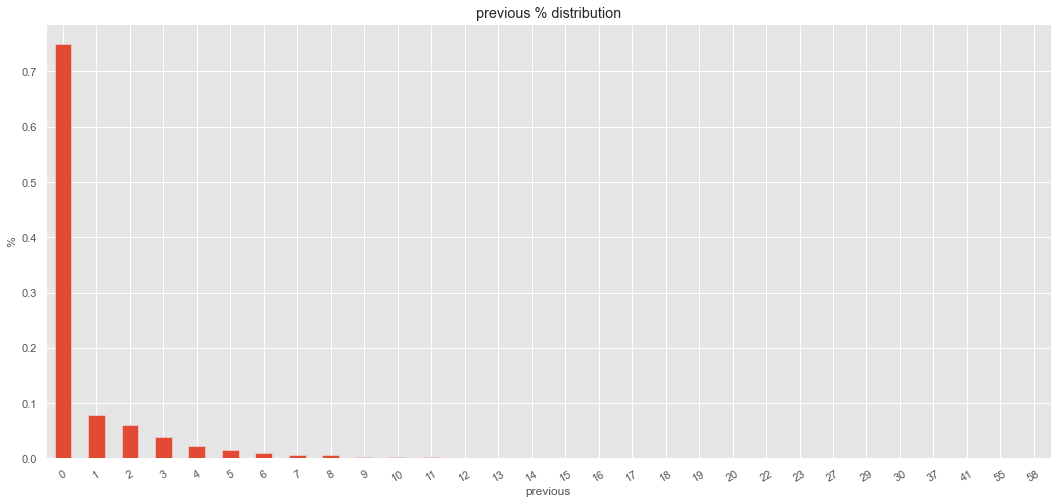

In [80]:
fig = plt.figure(figsize=(18, 8))
fig = (df['previous'].value_counts(normalize=True).sort_index()).plot.bar()
fig.set_xlabel('previous')
plt.xticks(rotation=30)
fig.set_ylabel('%')
fig.set_title('previous % distribution')
plt.show()

In [81]:
fig = px.box(
  data_frame=df,
  x='previous',
  color='deposit',
  height=500,
  width=900,
  title='Распределение количество контактов до текущей кампании previous в зависимости от класса целевого признака deposit')

fig.update_layout(margin=dict(l=10, r=10, t=40, b=0))
fig.show()

In [82]:
df[df['previous'] == 0]['deposit'].value_counts(True)

no     0.602801
yes    0.397199
Name: deposit, dtype: float64

In [83]:
df[df['previous'] != 0]['deposit'].value_counts(True)

yes    0.660229
no     0.339771
Name: deposit, dtype: float64

In [84]:
df[df['previous'] == 6]['deposit'].value_counts(True)

yes    0.700935
no     0.299065
Name: deposit, dtype: float64

Опять выглядит так, что можно признак привести к бинарному категориальному типу. 0 = 0 иначе 1

In [85]:
df['previous_new'] = df['previous'].apply(lambda x: False if x == 0 else True)

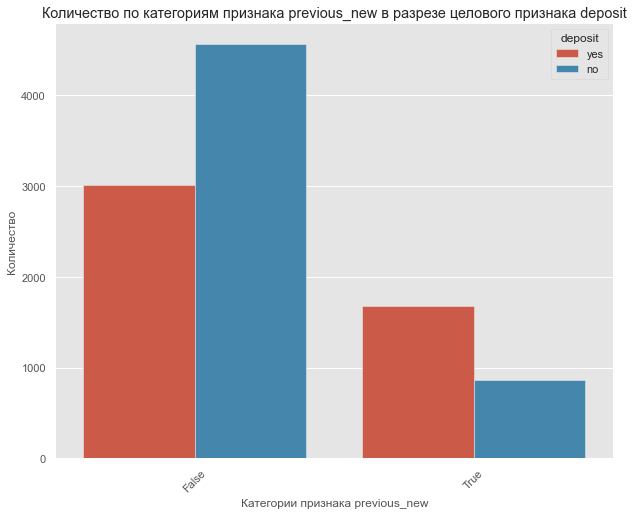

In [86]:
# Получаю список категорий отсортированных по убыванию доли во всей выборке
order_cat = df['previous_new'].value_counts().index.to_list()

fig = plt.figure(figsize=(10, 8))
sns.countplot(data=df, x='previous_new', hue='deposit', order=order_cat)
plt.title('Количество по категориям признака previous_new в разрезе целового признака deposit')
plt.xticks(rotation=45)
plt.xlabel('Категории признака previous_new')
plt.ylabel('Количество')
plt.show()

Данный признак полностью повторяет ранее сгенерированный was_previous_contact

In [87]:
# Удаляю, для сходимости результатов
df.drop(columns='previous_new', inplace=True)

### Задания 4 и 5

Теперь давайте рассмотрим описательные статистики для категориальных переменных.

Попробуйте извлечь максимум информации из тех показателей, которые можете получить. Сколько всего сфер занятости представлено среди клиентов банка? В каждый ли месяц проходила маркетинговая кампания? Какое семейное положение встречается чаще всего? А образование? Постарайтесь дать достаточно подробную интерпретацию. Для лучшей наглядности добавьте визуализации по каждой категориальной переменной.

In [88]:
# рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
df.describe(include='object')
# постройте визуализации, иллюстрирующие результаты

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


### Признак job
сфера занятости

In [89]:
df['job'].describe()

count          10105
unique            11
top       management
freq            2315
Name: job, dtype: object

In [90]:
# Доли каждой категории признака в %
df['job'].value_counts(normalize=True) * 100

management       22.909451
blue-collar      17.882237
technician       16.209797
admin.           12.330529
services          8.589807
retired           6.561108
self-employed     3.542801
unemployed        3.285502
student           3.226126
entrepreneur      2.968827
housemaid         2.493815
Name: job, dtype: float64

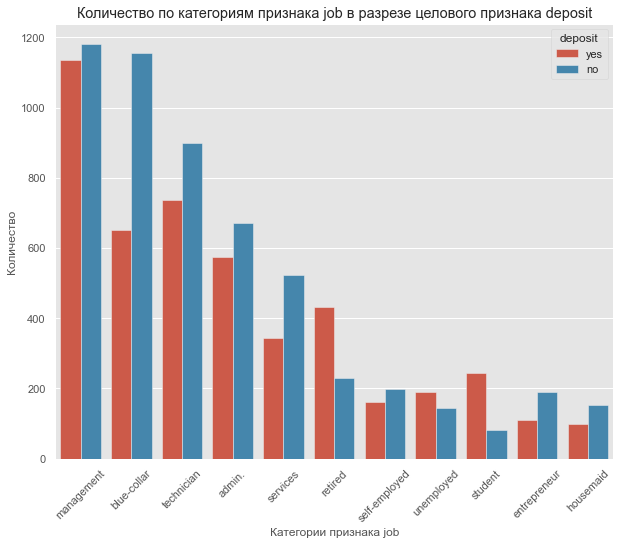

In [91]:
# Получаю список категорий отсортированных по убыванию доли во всей выборке
order_cat = df['job'].value_counts().index.to_list()

fig = plt.figure(figsize=(10, 8))
sns.countplot(data=df, x='job', hue='deposit', order=order_cat)
plt.title('Количество по категориям признака job в разрезе целового признака deposit')
plt.xticks(rotation=45)
plt.xlabel('Категории признака job')
plt.ylabel('Количество')
plt.show()

Удивительно, но среди тех кто не работает (student, retired, unemployed) больше тех, кто открывает депозиты.
В остальных категориях занятости всегда больше тех кто не открывает депозит. Наибольший относительно категории % отказа среди blue-collar (синие воротнички, т.е. рабочие). А в абсолютных числах больше всего отказов среди категории management и blue-collar

### Признак marital
семейное положение

In [92]:
df['marital'].describe()

count       10105
unique          3
top       married
freq         5715
Name: marital, dtype: object

In [93]:
# Доли каждой категории признака в %
df['marital'].value_counts(True) * 100

married     56.556160
single      31.796141
divorced    11.647699
Name: marital, dtype: float64

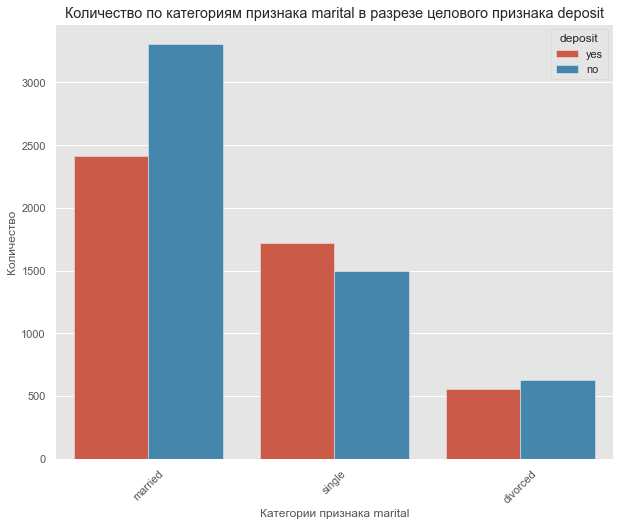

In [94]:
# Получаю список категорий отсортированных по убыванию доли во всей выборке
order_cat = df['marital'].value_counts().index.to_list()

fig = plt.figure(figsize=(10, 8))
sns.countplot(data=df, x='marital', hue='deposit', order=order_cat)
plt.title('Количество по категориям признака marital в разрезе целового признака deposit')
plt.xticks(rotation=45)
plt.xlabel('Категории признака marital')
plt.ylabel('Количество')
plt.show()

Имеется небольшой перевес категории в отношения (married) таких 56%. И у них больше всего % отказа от открытия депозита, так сказать есть куда деньги потратить.

Из трех категорий, только среди тех кто в разводе немного больше % тех кто открывает депозит.


### Признак education
уровень образования

In [95]:
df['education'].describe()

count         10105
unique            3
top       secondary
freq           5517
Name: education, dtype: object

In [96]:
# Доли каждой категории признака в %
df['education'].value_counts(True) * 100

secondary    54.596734
tertiary     32.053439
primary      13.349827
Name: education, dtype: float64

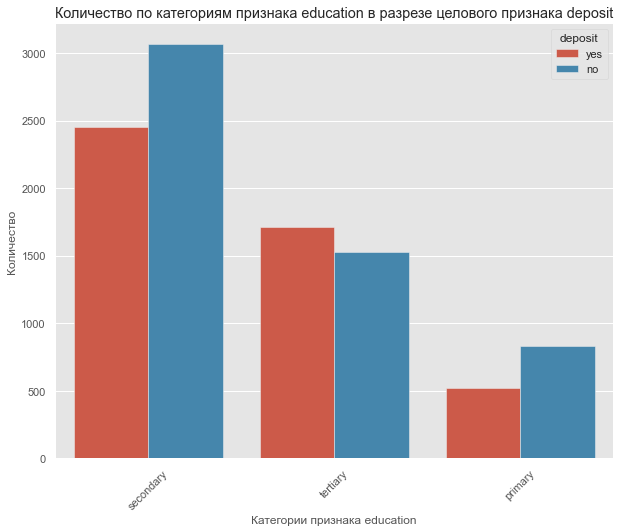

In [97]:
# Получаю список категорий отсортированных по убыванию доли во всей выборке
order_cat = df['education'].value_counts().index.to_list()

fig = plt.figure(figsize=(10, 8))
sns.countplot(data=df, x='education', hue='deposit', order=order_cat)
plt.title('Количество по категориям признака education в разрезе целового признака deposit')
plt.xticks(rotation=45)
plt.xlabel('Категории признака education')
plt.ylabel('Количество')
plt.show()

Только среди тех у кого высшее образование (tertiary) выше доля тех, кто открывает депозит

### Признак default
имеется ли просроченный кредит

In [98]:
df['default'].describe()

count     10105
unique        2
top          no
freq       9939
Name: default, dtype: object

In [99]:
# Доли каждой категории признака в %
df['default'].value_counts(True) * 100

no     98.357249
yes     1.642751
Name: default, dtype: float64

Дефолт достаточно редкое явление, всего у 1.6% клиентов он был

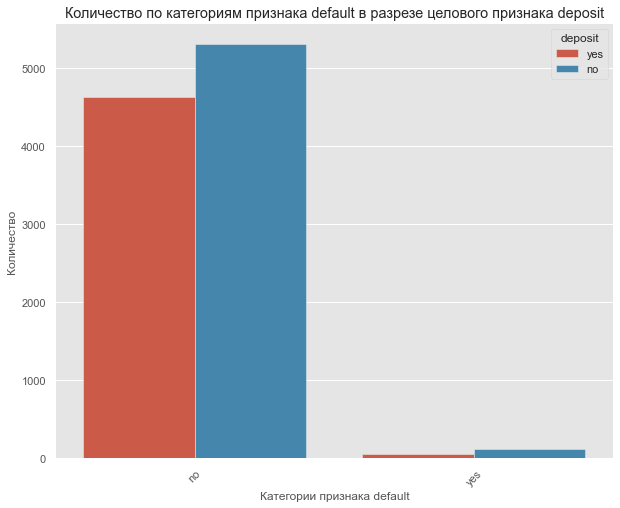

In [100]:
# Получаю список категорий отсортированных по убыванию доли во всей выборке
order_cat = df['default'].value_counts().index.to_list()

fig = plt.figure(figsize=(10, 8))
sns.countplot(data=df, x='default', hue='deposit', order=order_cat)
plt.title('Количество по категориям признака default в разрезе целового признака deposit')
plt.xticks(rotation=45)
plt.xlabel('Категории признака default')
plt.ylabel('Количество')
plt.show()

По обоим категориям больше тех, кто не открывает депозиты. Но внутри категории у тех у кого дефолт доля отказов в разы выше доли одобрений. В дефолте человеку совсем не до депозитов.

### Признак housing
имеется ли кредит на жильё

In [101]:
df['housing'].describe()

count     10105
unique        2
top          no
freq       5243
Name: housing, dtype: object

In [102]:
# Доли каждой категории признака в %
df['housing'].value_counts(True) * 100

no     51.885205
yes    48.114795
Name: housing, dtype: float64

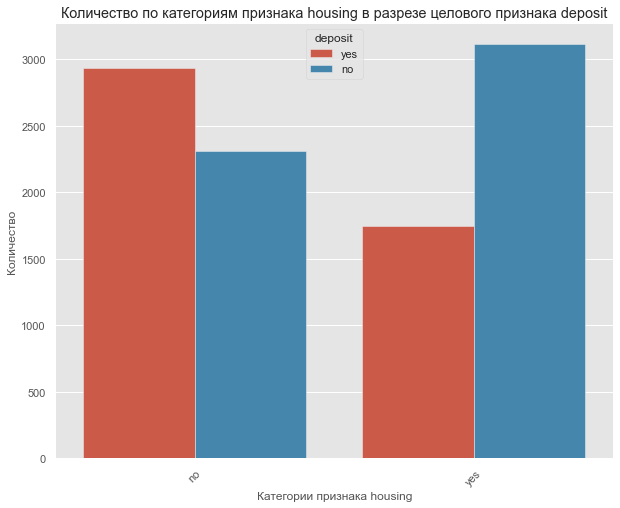

In [103]:
# Получаю список категорий отсортированных по убыванию доли во всей выборке
order_cat = df['housing'].value_counts().index.to_list()

fig = plt.figure(figsize=(10, 8))
sns.countplot(data=df, x='housing', hue='deposit', order=order_cat)
plt.title('Количество по категориям признака housing в разрезе целового признака deposit')
plt.xticks(rotation=45)
plt.xlabel('Категории признака housing')
plt.ylabel('Количество')
plt.show()

Примерно по-ровну тех у кого есть ипотека и у кого нет.
Среди тех у кого ипотека доля отказов почти в два раза выше чем тех кто открыл депозит.

А вот среди клиентов без ипотеки доля открывших депозит выше чем отказавшихся.
Логично что тем у кого открытая ипотека не до депозитов, они свободные деньги несут на погашение ипотеки прежде всего.

### Признак loan
имеется ли кредит на личные нужды

In [104]:
df['loan'].describe()

count     10105
unique        2
top          no
freq       8712
Name: loan, dtype: object

In [105]:
# Доли каждой категории признака в %
df['loan'].value_counts(True) * 100

no     86.214745
yes    13.785255
Name: loan, dtype: float64

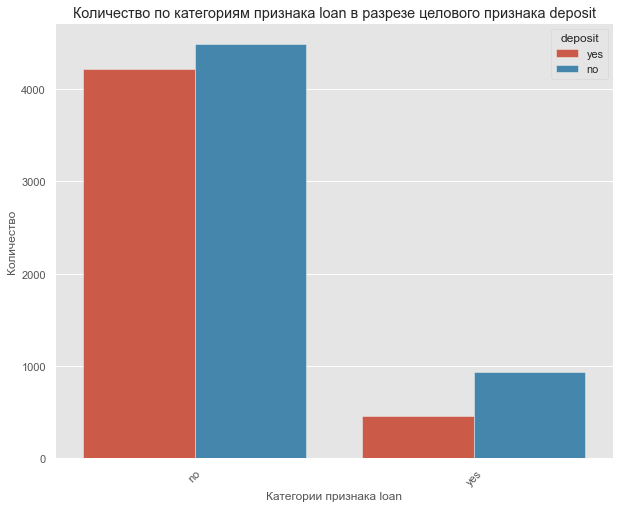

In [106]:
# Получаю список категорий отсортированных по убыванию доли во всей выборке
order_cat = df['loan'].value_counts().index.to_list()

fig = plt.figure(figsize=(10, 8))
sns.countplot(data=df, x='loan', hue='deposit', order=order_cat)
plt.title('Количество по категориям признака loan в разрезе целового признака deposit')
plt.xticks(rotation=45)
plt.xlabel('Категории признака loan')
plt.ylabel('Количество')
plt.show()

Если у клиента есть потребкредит, то доля отказа от депозита больше чем одобрение.

### Идея сделать числовой признак total_credits. со значениями 0,1,2

In [107]:
is_housing = df['housing'].apply(lambda x: 1 if x=='yes' else 0)
is_loan = df['loan'].apply(lambda x: 1 if x=='yes' else 0)
df['total_credits'] = is_housing + is_loan

In [108]:
df['total_credits'].value_counts(normalize=True) * 100

1    46.145473
0    45.977239
2     7.877288
Name: total_credits, dtype: float64

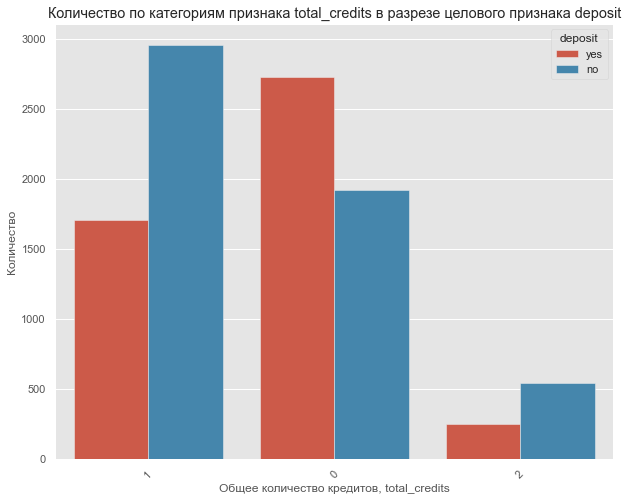

In [109]:
# Получаю список категорий отсортированных по убыванию доли во всей выборке
order_cat = df['total_credits'].value_counts().index.to_list()

fig = plt.figure(figsize=(10, 8))
sns.countplot(data=df, x='total_credits', hue='deposit', order=order_cat)
plt.title('Количество по категориям признака total_credits в разрезе целового признака deposit')
plt.xticks(rotation=45)
plt.xlabel('Общее количество кредитов, total_credits')
plt.ylabel('Количество')
plt.show()

Если нет кредитов, то доля открывющих депозиты выше чем отказывающих.
А для 1 и 2х кредитов характерно превышение доли отказывающих. Особенно для двух кредитов, в два раза превышение.

In [110]:
# сгенерированный прихнак удаляю, для сходимости результатов
df.drop(columns='total_credits', inplace=True)

### Признак contact
тип контакта с клиентом

In [111]:
df['contact'].describe()

count        10105
unique           3
top       cellular
freq          7283
Name: contact, dtype: object

In [112]:
# Доли каждой категории признака в %
df['contact'].value_counts(True) * 100

cellular     72.073231
unknown      21.385453
telephone     6.541316
Name: contact, dtype: float64

Как-то странно, если непонятно какой тип телефона - unknown. Почему это непонятно? Это ошибка, потеря информации или клиент не хочет предоставлять информацию.

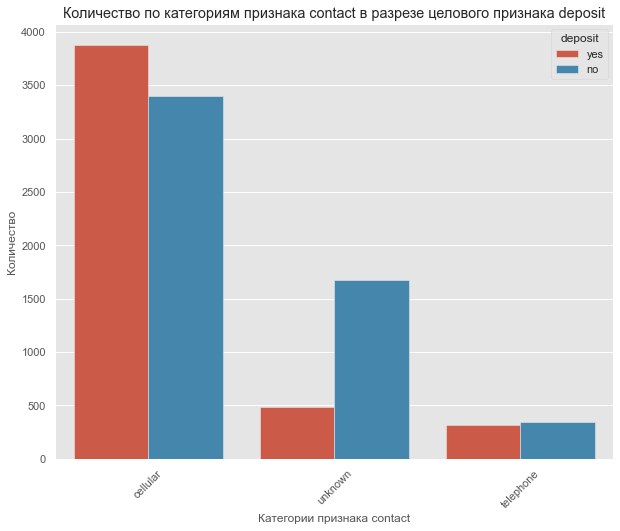

In [113]:
# Получаю список категорий отсортированных по убыванию доли во всей выборке
order_cat = df['contact'].value_counts().index.to_list()

fig = plt.figure(figsize=(10, 8))
sns.countplot(data=df, x='contact', hue='deposit', order=order_cat)
plt.title('Количество по категориям признака contact в разрезе целового признака deposit')
plt.xticks(rotation=45)
plt.xlabel('Категории признака contact')
plt.ylabel('Количество')
plt.show()

Те кому звонят на мобильники чаще соглашаются на депозит, на стационарные примерно пополам отказы и открытия депозитов.
А вот категория unknown это какие-то темные лошадки, про них неизвестно что у них за телефон и они сильно отказываются от депозитов, внутри категории доля отказов в 3 раза больше тех, кто согласился.

### Признак month
месяц, в котором был последний контакт

In [114]:
df['month'].describe()

count     10105
unique       12
top         may
freq       2617
Name: month, dtype: object

In [115]:
# Доли каждой категории признака в %
df['month'].value_counts(True) * 100

may    25.898070
jul    14.032657
aug    13.706086
jun    10.925285
apr     8.213756
nov     7.718951
feb     7.016329
oct     3.315190
jan     3.156853
sep     2.751113
mar     2.345374
dec     0.920336
Name: month, dtype: float64

Наибольшая активность в середине года с мая по август.

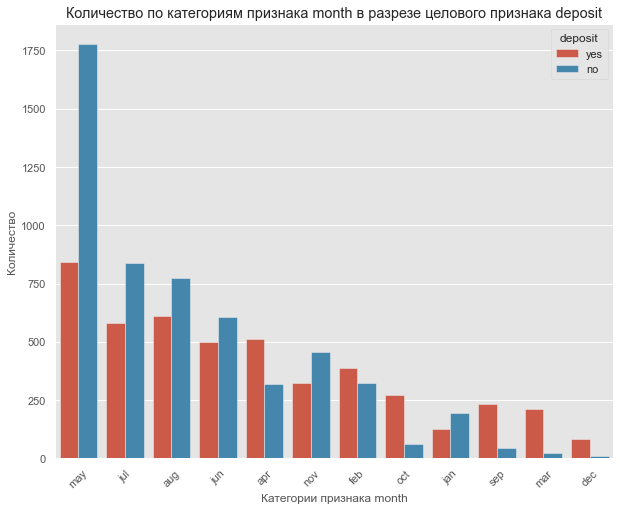

In [116]:
# Получаю список категорий отсортированных по убыванию доли во всей выборке
order_cat = df['month'].value_counts().index.to_list()

fig = plt.figure(figsize=(10, 8))
sns.countplot(data=df, x='month', hue='deposit', order=order_cat)
plt.title('Количество по категориям признака month в разрезе целового признака deposit')
plt.xticks(rotation=45)
plt.xlabel('Категории признака month')
plt.ylabel('Количество')
plt.show()

В мае больше всего контактов и количество открытых депозитов, но при этом относительная эффективность самая низкая. В 2 раза больше людей с кем связывались в мае отказались от открытия депозита.

А вот в сентябре, октябре, декабре, феврале, марте, апреле внури месяца доля открывающих депозиты выше.

### Признак poutcome
результат прошлой маркетинговой кампании

In [117]:
df['poutcome'].describe()

count       10105
unique          4
top       unknown
freq         7570
Name: poutcome, dtype: object

In [118]:
# Доли каждой категории признака в %
df['poutcome'].value_counts(True) * 100

unknown    74.913409
failure    10.974765
success     9.351806
other       4.760020
Name: poutcome, dtype: float64

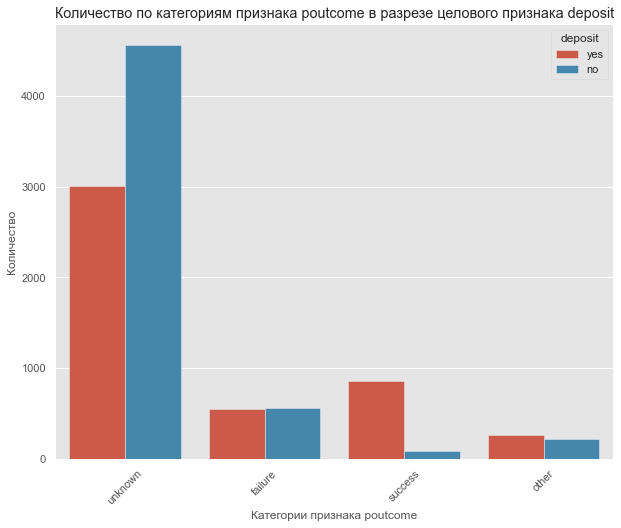

In [119]:
# Получаю список категорий отсортированных по убыванию доли во всей выборке
order_cat = df['poutcome'].value_counts().index.to_list()

fig = plt.figure(figsize=(10, 8))
sns.countplot(data=df, x='poutcome', hue='deposit', order=order_cat)
plt.title('Количество по категориям признака poutcome в разрезе целового признака deposit')
plt.xticks(rotation=45)
plt.xlabel('Категории признака poutcome')
plt.ylabel('Количество')
plt.show()

Хорошо видно что те кто участвовал в предыдущей программе так же соглашаются открыть депозит. Внутри этой категории открытия во много раз выше отказов. Категория unknown - непонятная, почему нет информации? Но при этом она самая большая в признаке. И внутри нее явный перекос в неуспешные звонки.

Может unknown это какие-то необщительные клиенты, которые максимально быстро рвут связь.

### Задание 6

In [120]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
df.groupby(['poutcome', 'deposit']).agg({'poutcome': 'count'}).rename(columns={'poutcome': 'count'}).T

poutcome failure      other      success      unknown      
deposit       no  yes    no  yes      no  yes      no   yes
count        562  547   216  265      84  861    4562  3008

Success и Other. Это видно из графика и вот из такой таблицы группировки.

### Задание 7

In [121]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
df.groupby(['month', 'deposit']).agg({'deposit': 'count'}).rename(columns={'deposit': 'count'})

count
month deposit       
apr   no         317
      yes        513
aug   no         775
      yes        610
dec   no           9
      yes         84
feb   no         323
      yes        386
jan   no         194
      yes        125
jul   no         836
      yes        582
jun   no         606
      yes        498
mar   no          24
      yes        213
may   no        1776
      yes        841
nov   no         456
      yes        324
oct   no          62
      yes        273
sep   no          46
      yes        232

В мае больше всего отказов в абсолютных значениях.

### Задание 8

In [122]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
df['age'].describe()

count    10105.000000
mean        40.895497
std         11.734931
min         18.000000
25%         32.000000
50%         38.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64

Выведу частотность возрастов отсортированную по возрастанию самих возрастов, фактически это гистограмма с количеством корзин равных диапазону min-max возрастов в годах

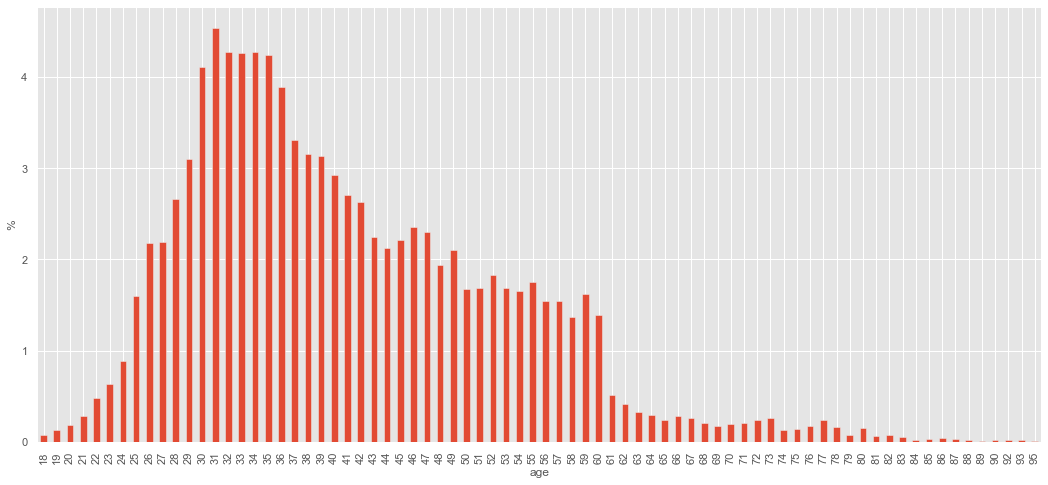

In [123]:
fig = plt.figure(figsize=(18, 8))
fig = (df['age'].value_counts(True).sort_index() * 100).plot.bar()
fig.set_xlabel('age')
fig.set_ylabel('%');

Классическая диаграмма распределения для возрастов

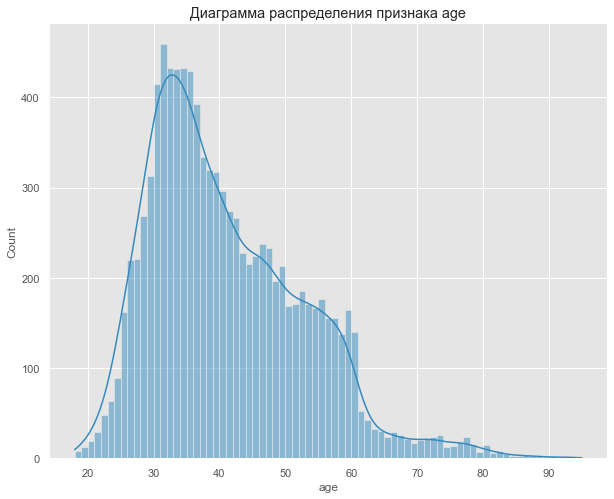

In [124]:
fig = plt.figure(figsize=(10, 8))
histplot = sns.histplot(data=df, x='age', bins=77, kde='mean')
histplot.set_title('Диаграмма распределения признака age')
plt.show()

Выделяю следующие группы исходя из логики и гистограммы:
* teenager - до 22 включительно.
* young - от 23 до 35 включительно.
* medium - от 36 до 44 включительно.
* older - от 45 до 60 включительно.
* oldest - от 61

In [125]:
# def age_group(age):
#   if age <= 22:
#     return 'teenager'
#   elif 23 <= age <= 35:
#     return 'young'
#   elif 36 <= age <= 44:
#     return 'medium'
#   elif 45 <= age <= 60:
#     return 'older'
#   elif age >= 61:
#     return 'oldest'
#   else:
#     return 'error'

In [126]:
# df['age_group'] = df['age'].apply(age_group)
# df['age_group'] = df['age_group'].astype('category')

In [127]:
bins = [0, 22, 35, 44, 60, 100]
category = ['<22', '22-35', '35-44', '44-60', '60+']
df['age_group'] = pd.cut(df['age'], bins, labels=category, right=True)

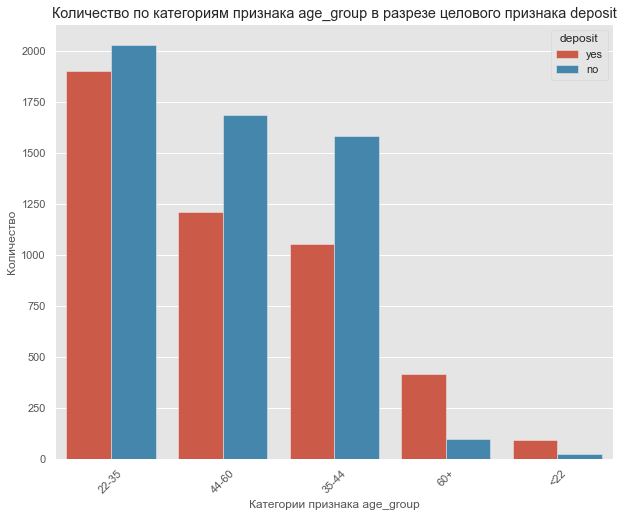

In [128]:
# Получаю список категорий отсортированных по убыванию доли во всей выборке
order_cat = df['age_group'].value_counts().index.to_list()

fig = plt.figure(figsize=(10, 8))
sns.countplot(data=df, x='age_group', hue='deposit', order=order_cat)
plt.title('Количество по категориям признака age_group в разрезе целового признака deposit')
plt.xticks(rotation=45)
plt.xlabel('Категории признака age_group')
plt.ylabel('Количество')
plt.show()

In [129]:
# для сходимости результатов удаляю свой признак
df.drop(columns='age_group', inplace=True)

В группах возрастов видно что возрастные края teenager, oldest чаще соглашаются на открытие депозитов.
А вот люди среднего возраста чаще отказыватся. young, medium, older

Нам бы очень хотелось посмотреть, люди какого возраста чаще открывают депозиты, а какого — реже. Однако, так как возрастной разброс достаточно большой, визуализация для всех возрастов или нахождение статистики для каждого возраста не будет содержательным. В аналитике принято разделять людей по возрастным подгруппам и делать выводы уже по ним.

Создайте новую переменную, в которой будет находиться индикатор принадлежности к одной из следующих категорий:

'<30';
'30-40';
'40-50';
'50-60';
'60+'.

In [130]:
bins = [0, 30, 40, 50, 60, 9999]
category = ['<30', '30-40', '40-50', '50-60', '60+']
df['age_group'] = pd.cut(df['age'], bins, labels=category)

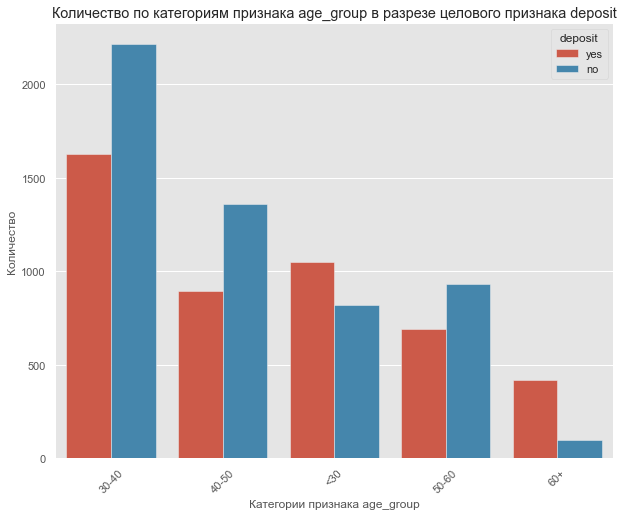

In [131]:
# Получаю список категорий отсортированных по убыванию доли во всей выборке
order_cat = df['age_group'].value_counts().index.to_list()

fig = plt.figure(figsize=(10, 8))
sns.countplot(data=df, x='age_group', hue='deposit', order=order_cat)
plt.title('Количество по категориям признака age_group в разрезе целового признака deposit')
plt.xticks(rotation=45)
plt.xlabel('Категории признака age_group')
plt.ylabel('Количество')
plt.show()

### Задания 9 и 10

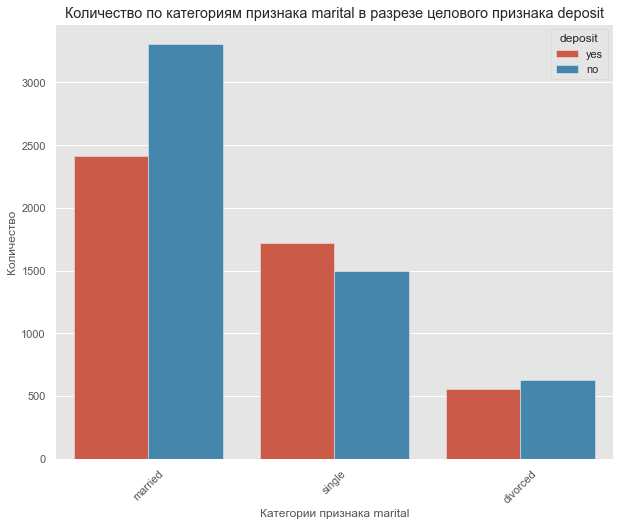

In [132]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

# Получаю список категорий отсортированных по убыванию доли во всей выборке
order_cat = df['marital'].value_counts().index.to_list()

fig = plt.figure(figsize=(10, 8))
sns.countplot(data=df, x='marital', hue='deposit', order=order_cat)
plt.title('Количество по категориям признака marital в разрезе целового признака deposit')
plt.xticks(rotation=45)
plt.xlabel('Категории признака marital')
plt.ylabel('Количество')
plt.show()

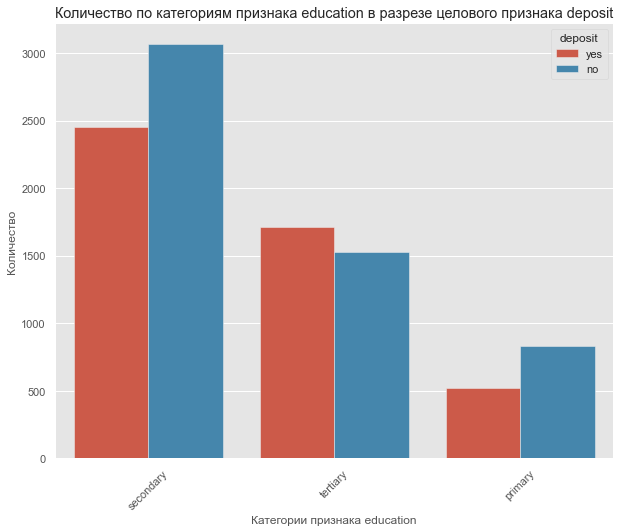

In [133]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

# Получаю список категорий отсортированных по убыванию доли во всей выборке
order_cat = df['education'].value_counts().index.to_list()

fig = plt.figure(figsize=(10, 8))
sns.countplot(data=df, x='education', hue='deposit', order=order_cat)
plt.title('Количество по категориям признака education в разрезе целового признака deposit')
plt.xticks(rotation=45)
plt.xlabel('Категории признака education')
plt.ylabel('Количество')
plt.show()

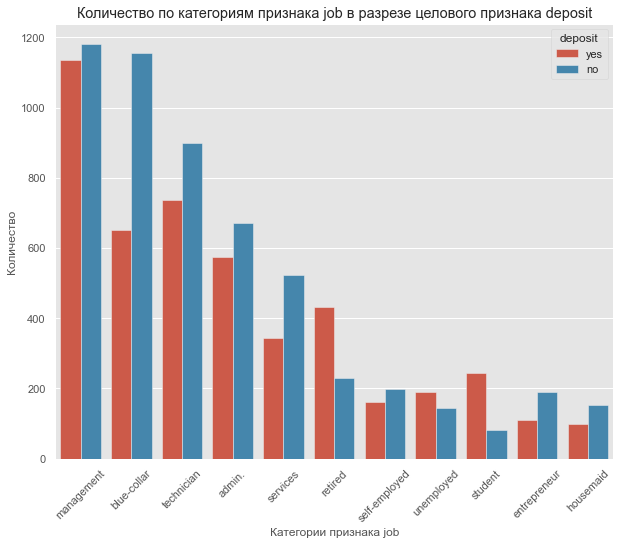

In [134]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

# Получаю список категорий отсортированных по убыванию доли во всей выборке
order_cat = df['job'].value_counts().index.to_list()

fig = plt.figure(figsize=(10, 8))
sns.countplot(data=df, x='job', hue='deposit', order=order_cat)
plt.title('Количество по категориям признака job в разрезе целового признака deposit')
plt.xticks(rotation=45)
plt.xlabel('Категории признака job')
plt.ylabel('Количество')
plt.show()

### Задание 11

In [135]:
df['education'].value_counts()

secondary    5517
tertiary     3239
primary      1349
Name: education, dtype: int64

In [136]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

# что бы использовать агрегацию по count нужно использовать для этого в качестве values какой-то числовой признак
pivot_df = df.pivot_table(values='age', index=['education', 'marital'], columns='deposit', aggfunc='count')
pivot_df

deposit               no   yes
education marital             
primary   divorced    91    96
          married    641   339
          single     100    82
secondary divorced   370   283
          married   1830  1289
          single     866   879
tertiary  divorced   163   174
          married    832   784
          single     531   755

Больше всего открыли депозиты married с образованием secondary

Давайте посмотрим, как зависит соотношение успешных и неуспешных контактов с клиентами от категорий, к которым относятся клиенты:

семейное положение;
уровень образования;
сфера занятости.
Постройте визуализации, отражающие количество тех, кто открыл депозит, и тех, кто его не открыл, для всех категорий предложенных выше трёх признаков. Постарайтесь оформить диаграммы максимально наглядно и описать полученный результат.

К каким категориям относится бόльшая часть людей? Среди каких групп населения есть тенденция соглашаться открывать депозит, а среди каких — отказываться?

In [137]:
pivot_df = df.pivot_table(values='age', index=['deposit','job'], columns=['marital', 'education'], aggfunc='count')
pivot_df

marital               divorced                    married                     \
education              primary secondary tertiary primary secondary tertiary   
deposit job                                                                    
no      admin.             2.0      85.0      2.0    24.0     305.0     26.0   
        blue-collar       36.0      51.0      NaN   344.0     477.0     10.0   
        entrepreneur       2.0      14.0     10.0    23.0      69.0     49.0   
        housemaid         12.0      10.0      2.0    72.0      33.0     11.0   
        management         5.0      15.0    111.0    36.0     122.0    541.0   
        retired           17.0      20.0      7.0    66.0      84.0     25.0   
        self-employed      NaN       8.0      6.0    15.0      66.0     50.0   
        services          14.0      54.0      1.0    27.0     262.0     13.0   
        student            NaN       NaN      1.0     1.0       2.0      2.0   
        technician         1.0      97.0     22.0    19.0     352.0     95.0   
        unemployed         2.0      16.0      1.0    14.0      58.0     10.0   
yes     admin.             3.0      75.0      4.0     7.0     226.0     40.0   
        blue-collar       30.0      22.0      NaN   132.0     265.0      4.0   
        entrepreneur       NaN       7.0      7.0     8.0      32.0     31.0   
        housemaid         11.0       4.0      1.0    28.0      24.0      9.0   
        management         NaN      20.0     99.0    18.0      99.0    485.0   
        retired           44.0      35.0     25.0   104.0     154.0     57.0   
        self-employed      1.0       4.0     14.0     3.0      27.0     35.0   
        services           4.0      42.0      2.0    17.0     139.0      3.0   
        student            NaN       NaN      1.0     1.0       7.0      2.0   
        technician         1.0      54.0     17.0     8.0     253.0    103.0   
        unemployed         2.0      20.0      4.0    13.0      63.0     15.0   

marital                single                     
education             primary secondary tertiary  
deposit job                                       
no      admin.            3.0     188.0     37.0  
        blue-collar      59.0     169.0      9.0  
        entrepreneur      1.0      10.0     11.0  
        housemaid         5.0       5.0      3.0  
        management        NaN      48.0    302.0  
        retired           6.0       4.0      2.0  
        self-employed     6.0      16.0     30.0  
        services          7.0     133.0     12.0  
        student           4.0      54.0     17.0  
        technician        5.0     215.0     94.0  
        unemployed        4.0      24.0     14.0  
yes     admin.            2.0     172.0     45.0  
        blue-collar      35.0     145.0     19.0  
        entrepreneur      2.0      13.0     11.0  
        housemaid         7.0       6.0      9.0  
        management        1.0      32.0    381.0  
        retired           2.0       5.0      6.0  
        self-employed     NaN      10.0     67.0  
        services          6.0     116.0     16.0  
        student          13.0     175.0     46.0  
        technician        NaN     177.0    125.0  
        unemployed       14.0      28.0     30.0

В предыдущих заданиях мы посмотрели различные категории отдельно. Но что будет, если посмотреть на пересечения категорий? Каких людей среди открывших депозит больше: одиноких с высшим образованием или разведённых с более низким уровнем образования?

Разделите таблицу на две части: для тех, кто открыл депозит, и для тех, кто не открыл. Для каждой части постройте сводную диаграмму по уровню образования и семейному положению. Представьте результаты в виде тепловых карт. Различаются ли наиболее популярные группы для открывших депозит и для неоткрывших? Какой вывод вы можете сделать, исходя из полученных данных?

In [138]:
yes_pivot_df = df[df['deposit'] == 'yes'].pivot_table(values='age', index='education', columns='marital', aggfunc='count')
yes_pivot_df

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


In [139]:
no_pivot_df = df[df['deposit'] == 'no'].pivot_table(values='age', index='education', columns='marital', aggfunc='count')
no_pivot_df

marital,divorced,married,single
education,,,
primary,91,641,100
secondary,370,1830,866
tertiary,163,832,531


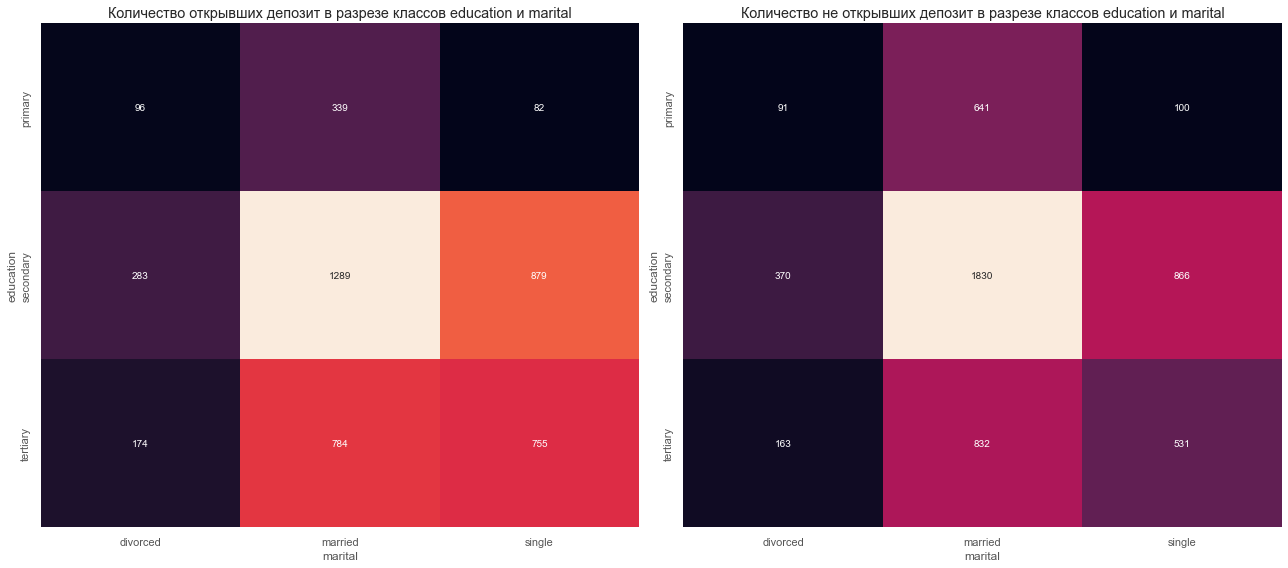

In [140]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
yes_heat = sns.heatmap(yes_pivot_df, annot=True, fmt='.0f', cbar=False, ax=axes[0])
yes_heat.set_title('Количество открывших депозит в разрезе классов education и marital')

no_heat = sns.heatmap(no_pivot_df, annot=True, fmt='.0f', cbar=False, ax=axes[1])
no_heat.set_title('Количество не открывших депозит в разрезе классов education и marital')

plt.tight_layout()
plt.show()

Наибольшее количество как открывших так и отказавшихся от депозита клиентов находятся в одной группе married-secondary.
Думаю это просто была целевая группа на которой были сосредоточены сотрудники банка.
Таргетирование было направлено именно на них.

## Часть 3: преобразование данных

### Задание 1

In [141]:
df.reset_index(drop=True, inplace=True)

In [142]:
# преобразуйте уровни образования
# df = pd.get_dummies(df, columns=['education'])
le = LabelEncoder()
df['education'] = pd.Series(le.fit_transform(df['education']))

In [143]:
df['age_group'] = pd.Series(le.fit_transform(df['age_group']))

In [144]:
df.drop(columns='age', inplace=True)

### Задания 2 и 3

Преобразование целевой переменной

In [145]:
df['deposit'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

In [146]:
# Вычислите стандартное отклонение по преобразованной в корректный вид целевой переменной deposit. 
# Ответ округлите до трёх знаков после точки-разделителя.
round(df['deposit'].std(), 3)

0.499

Преобразование переменных default, housing, loan

преобразуйте бинарные переменные в представление из нулей и единиц

In [147]:
to_transform = ['default', 'housing', 'loan']
def code_yes_no(x):
  if x == 'yes':
    return 1
  return 0

In [148]:
# Кодирую признаки из списка
for col in to_transform:
  df[col] = df[col].apply(code_yes_no)

In [149]:
# Вычислите среднее арифметическое для каждой из получившихся переменных, 
# сложите три результата и в качестве ответа впишите итог, 
# округлив его до трёх знаков после точки-разделителя.
total_sum = 0
for col in to_transform:
  total_sum = total_sum + df[col].mean()
  
round(total_sum, 3)

0.635

### Задание 4

In [150]:
category_nominal_cols = ['job', 'marital', 'contact', 'month', 'poutcome']

In [151]:
df = pd.get_dummies(df, columns=category_nominal_cols)

### Задания 5 и 6

In [152]:
cols = df.columns.to_list()
cols.remove('deposit')
cols.insert(0, 'deposit')

In [153]:
df = df[cols]

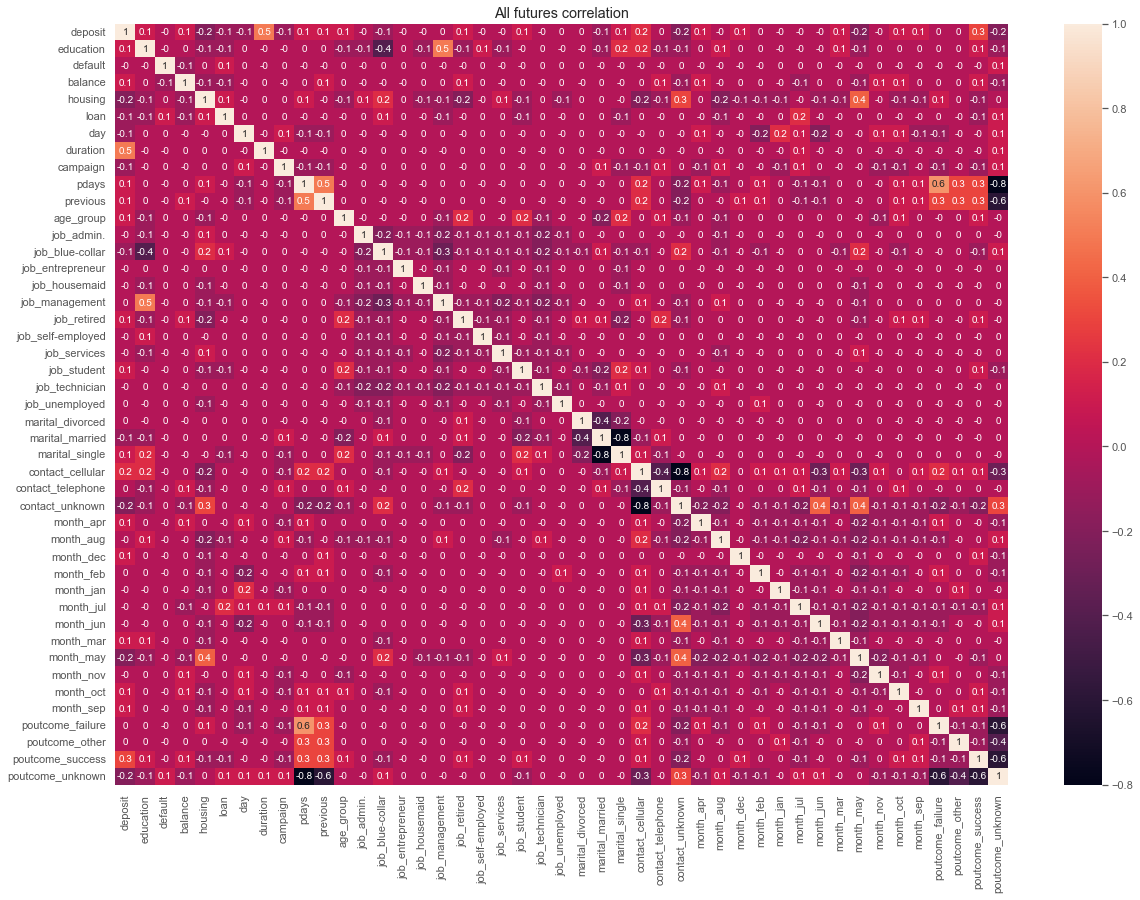

In [154]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
fig = plt.figure(figsize=(20, 14))
hm = sns.heatmap(df.corr().round(1), annot=True, fmt='.1g')
hm.set_title('All futures correlation')
plt.show()

Мультиколлинеарности не наблюдаю. Но есть высокая отрицательная корреляция в изначально одном признаке, contact.
Между unknown и cellular типами контактов.

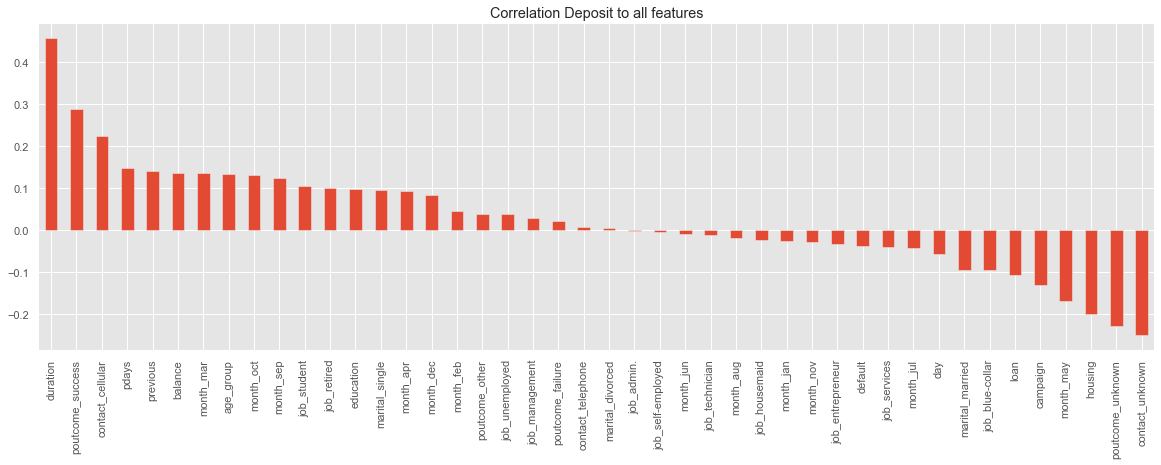

In [155]:
fig = plt.figure(figsize=(20, 6))
df.corr()['deposit'].drop(index='deposit').sort_values(ascending=False).plot.bar()
plt.title('Correlation Deposit to all features');

### Задания 7 и 8

In [156]:
X = df.drop(columns='deposit')
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.33)

In [157]:
# рассчитайте необходимые показатели

# Каким получился размер тестовой выборки?
X_test.shape[0]

3335

In [158]:
# Каково среднее значение целевой переменной на тестовой выборке? Ответ округлите до двух знаков после точки-разделителя.
round(y_test.mean(), 2)

0.46

### Задание 9

С помощью SelectKBest отберите 15 наиболее подходящих признаков.

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. 

Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.

С помощью SelectKBest отберите 15 признаков, наилучшим образом подходящих для использования в задаче. 

Отбор реализуйте по обучающей выборке, используя параметр score_func = f_classif.

Помните, что на данном этапе вам необходимо оставить только те признаки, которые содержат лишь числовые значения.

In [159]:
from sklearn.feature_selection import SelectKBest, f_classif

In [160]:
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
select_features = selector.get_feature_names_out()
list(select_features)

['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_group',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

In [161]:
# Оставляю в выборках лишь наиболее важные признаки отобранные с помощью SelectKBest
X_train = X_train[select_features]
X_test = X_test[select_features]

### Задание 10

Теперь данные необходимо нормализовать.

Есть разные варианты нормализации, но мы будем использовать min-max-нормализацию.

Помните, что нормализация требуется для предикторов, а не для целевой переменной.

Нормализуйте предикторы в обучающей и тестовой выборках.

In [162]:
# нормализуйте данные с помощью minmaxsxaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [163]:
# Задание 4.10
# Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из тестовой выборки. 
# Ответ округлите до двух знаков после точки-разделителя.
round(X_test_scaled[:, 0].mean(), 2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

##### обучите логистическую регрессию и рассчитайте метрики качества

In [164]:
from sklearn.linear_model import LogisticRegression

Для начала реализуем самый простой алгоритм, который вам известен — логистическую регрессию.

В качестве алгоритма оптимизации будем использовать 'sag', 

в качестве значения параметра random_state возьмём число 42 и запустим 1000 итераций.

In [165]:
lr = LogisticRegression(solver='sag', max_iter=1000, random_state=42)

In [166]:
lr.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [167]:
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

In [168]:
hd.print_classification_metrics(y_train, y_train_pred, y_test, y_test_pred)

*** TRAIN ***
Accuracy: 0.82
Precision: 0.84
Recall: 0.76
F1 score: 0.80

*** TEST ***
Accuracy: 0.81
Precision: 0.83
Recall: 0.74
F1 score: 0.78


In [169]:
print('*** TRAIN ***')
print(metrics.classification_report(y_train, y_train_pred))
print()
print('*** TEST ***')
print(metrics.classification_report(y_test, y_test_pred))

*** TRAIN ***
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770


*** TEST ***
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.74      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задания 2,3,4
Простой алгоритм обучен. Теперь давайте обучим ещё один алгоритм — решающие деревья. 

В качестве параметров для начала возьмём следующие:
* criterion = 'entropy';
* random_state = 42.
* Остальные параметры оставьте по умолчанию.

In [170]:
dt = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)

In [171]:
dt.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [172]:
y_train_pred = dt.predict(X_train_scaled)
y_test_pred = dt.predict(X_test_scaled)

In [173]:
hd.print_classification_metrics(y_train, y_train_pred, y_test, y_test_pred)

*** TRAIN ***
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 score: 1.00

*** TEST ***
Accuracy: 0.75
Precision: 0.73
Recall: 0.72
F1 score: 0.73


In [174]:
print('*** TRAIN ***')
print(metrics.classification_report(y_train, y_train_pred))
print()
print('*** TEST ***')
print(metrics.classification_report(y_test, y_test_pred))

*** TRAIN ***
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770


*** TEST ***
              precision    recall  f1-score   support

           0       0.76      0.77      0.77      1790
           1       0.73      0.72      0.73      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335



### Задание 5
Переберите различные максимальные глубины деревьев и найдите глубину дерева, для которой будет максимальное значение метрики accuracy, но при этом ещё не будет наблюдаться переобучения (т. е. не будет расти качество на обучающей выборке при неизменном качестве на тестовой).

In [175]:
dt = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=6)
dt.fit(X_train_scaled, y_train)
y_train_pred = dt.predict(X_train_scaled)
y_test_pred = dt.predict(X_test_scaled)
hd.print_classification_metrics(y_train, y_train_pred, y_test, y_test_pred)

*** TRAIN ***
Accuracy: 0.82
Precision: 0.77
Recall: 0.86
F1 score: 0.81

*** TEST ***
Accuracy: 0.81
Precision: 0.76
Recall: 0.84
F1 score: 0.80


In [176]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

param_grid = {
    'max_depth': np.arange(1, 11),
    }

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
        criterion='entropy', 
        random_state=42,
    ), 
    param_grid=param_grid, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs = -1,
    scoring='accuracy'
)  

%time grid_search.fit(X_train_scaled, y_train) 
y_train_pred = grid_search.predict(X_train_scaled)
y_test_pred = grid_search.predict(X_test_scaled)

CPU times: total: 109 ms
Wall time: 3.27 s


In [177]:
hd.print_classification_metrics(y_train, y_train_pred, y_test, y_test_pred)

*** TRAIN ***
Accuracy: 0.84
Precision: 0.81
Recall: 0.85
F1 score: 0.83

*** TEST ***
Accuracy: 0.81
Precision: 0.79
Recall: 0.82
F1 score: 0.80


In [178]:
grid_search.best_params_

{'max_depth': 7}

Разумеется, у каждой модели может быть множество параметров. 

Перебирать их вручную, чтобы получить наилучшее качество, долго и трудозатратно. 

Поэтому мы можем использовать оптимизацию: можно перебрать сразу большое количество комбинаций различных параметров и выбрать тот вариант, при котором модель будет давать наиболее точный прогноз.

Реализуйте оптимизацию гиперпараметров с помощью GridSearch, перебрав следующие параметры:

'min_samples_split': [2, 5, 7, 10];

'max_depth':[3,5,7].

In [179]:
param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth': [3, 5, 7]
    }

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
        criterion='entropy', 
        random_state=42,
    ), 
    param_grid=param_grid, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs = -1,
    scoring='f1'
)  

%time grid_search.fit(X_train_scaled, y_train) 
y_train_pred = grid_search.predict(X_train_scaled)
y_test_pred = grid_search.predict(X_test_scaled)

CPU times: total: 62.5 ms
Wall time: 181 ms


In [180]:
hd.print_classification_metrics(y_train, y_train_pred, y_test, y_test_pred)

*** TRAIN ***
Accuracy: 0.84
Precision: 0.81
Recall: 0.84
F1 score: 0.83

*** TEST ***
Accuracy: 0.81
Precision: 0.79
Recall: 0.82
F1 score: 0.80


In [181]:
grid_search.best_params_

{'max_depth': 7, 'min_samples_split': 10}

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1
Обучите случайный лес со следующими параметрами:
* n_estimators = 100;
* criterion = 'gini';
* min_samples_leaf = 5;
* max_depth = 10;
* random_state = 42.

In [204]:
# обучите на ваших данных случайный лес
rfc = ensemble.RandomForestClassifier(n_estimators=100,
                                criterion='gini',
                                min_samples_leaf=5,
                                max_depth=10,
                                random_state=42)

In [205]:
%time rfc.fit(X_train_scaled, y_train)
y_train_pred = rfc.predict(X_train_scaled)
y_test_pred = rfc.predict(X_test_scaled)

CPU times: total: 125 ms
Wall time: 295 ms


In [206]:
hd.print_classification_metrics(y_train, y_train_pred, y_test, y_test_pred)

*** TRAIN ***
Accuracy: 0.86
Precision: 0.84
Recall: 0.86
F1 score: 0.85

*** TEST ***
Accuracy: 0.83
Precision: 0.80
Recall: 0.83
F1 score: 0.82


### Задания 2 и 3
Дата-сайентист не должен останавливаться на одной модели — он должен пробовать все доступные варианты. Поэтому теперь предлагаем вам сравнить полученные результаты с моделью градиентного бустинга. 

Используйте градиентный бустинг для решения задачи классификации, задав для него следующие параметры:
* learning_rate = 0.05;
* n_estimators = 300;
* min_samples_leaf = 5;
* max_depth = 5;
* random_state = 42.

In [245]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gbc0 = ensemble.GradientBoostingClassifier(learning_rate=0.05,
                                          n_estimators=300,
                                          min_samples_leaf=5,
                                          max_depth=5,
                                          random_state=42)

In [246]:
%time gbc0.fit(X_train_scaled, y_train)
y_train_pred = gbc0.predict(X_train_scaled)
y_test_pred = gbc0.predict(X_test_scaled)

CPU times: total: 2.86 s
Wall time: 4.33 s


In [247]:
hd.print_classification_metrics(y_train, y_train_pred, y_test, y_test_pred)

*** TRAIN ***
Accuracy: 0.89
Precision: 0.87
Recall: 0.89
F1 score: 0.88

*** TEST ***
Accuracy: 0.83
Precision: 0.80
Recall: 0.83
F1 score: 0.82


* Количество деревьев (n_estimators). Чем больше деревьев вы берёте, тем меньше ошибка на обучающем наборе данных, вплоть до 0, но, как вы понимаете, тем выше шанс переобучиться. Лучше начинать с небольшого количества моделей (50-100), а затем следить за ошибкой на тестовой выборке.
* Темп обучения  (learning_rate). Чем выше темп обучения, тем больше вклад каждого следующего дерева будет в модель и тем быстрее вы сойдётесь к минимуму функции потерь и сведёте ошибку к 0. Однако снова высок риск переобучения. Рекомендуемые значения — от 0.01 до 1.
* Максимальная глубина деревьев (max_depth). Градиентный бустинг лучше всего работает со слабыми моделями — это короткие деревья решений с глубиной от 1 до 8.

In [217]:
param_grid = {
    'n_estimators': np.arange(10, 100, 10),
    'learning_rate': np.arange(0, 0.3, 0.025),
    'max_depth': np.arange(1, 7, 1)
    }

gbc = ensemble.GradientBoostingClassifier(min_samples_leaf=5,
                                          random_state=42)

grid_search = GridSearchCV(
    estimator=gbc, 
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs = -1,
    scoring='f1'
)  

%time grid_search.fit(X_train_scaled, y_train) 
y_train_pred = grid_search.predict(X_train_scaled)
y_test_pred = grid_search.predict(X_test_scaled)

CPU times: total: 10.8 s
Wall time: 1min 46s


In [218]:
hd.print_classification_metrics(y_train, y_train_pred, y_test, y_test_pred)

*** TRAIN ***
Accuracy: 0.86
Precision: 0.84
Recall: 0.86
F1 score: 0.85

*** TEST ***
Accuracy: 0.83
Precision: 0.80
Recall: 0.83
F1 score: 0.82


In [219]:
# Лучшие параметры градиентного бустинга выбранные в результате поиска по сетке со стратифицированной кросс-валидацией
grid_search.best_params_

{'learning_rate': 0.125, 'max_depth': 4, 'n_estimators': 80}

In [222]:
# Лучшая модель градиентного бустинга выбранная в результате поиска по сетке со стратифицированной кросс-валидацией
grid_search.best_estimator_

GradientBoostingClassifier(learning_rate=0.125, max_depth=4, min_samples_leaf=5,
                           n_estimators=80, random_state=42)

### Задание 4
Вы уже попробовали построить разные модели, и теперь пришло время построить ансамбль из моделей разного типа.

В этом задании вам необходимо использовать стекинг, объединив те алгоритмы, которые вы уже использовали ранее: 
- решающие деревья, 
- логистическую регрессию
- градиентный бустинг. 

В качестве метамодели используйте модель логистической регрессии.

Параметры оставьте те же, что были в ваших алгоритмах в предыдущих заданиях.

In [223]:
# объедините уже известные вам алгоритмы с помощью стекинга
random_state=42

dt = tree.DecisionTreeClassifier(max_depth=7,
                            min_samples_split=10,
                            criterion='entropy',
                            random_state=random_state)

lr = LogisticRegression(solver='sag',
                        max_iter=1000,
                        random_state=random_state)

gbc = ensemble.GradientBoostingClassifier(learning_rate=0.125,
                                                max_depth=4,
                                                n_estimators=80,
                                                min_samples_leaf=5,
                                                random_state=random_state)

# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('dt', dt),
    ('lr', lr),
    ('gbc', gbc)
]

# Создаем объект класса стекинг
stc = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=random_state)
)

%time stc.fit(X_train_scaled, y_train) 
y_train_pred = stc.predict(X_train_scaled)
y_test_pred = stc.predict(X_test_scaled)

CPU times: total: 2.59 s
Wall time: 4.72 s


In [224]:
hd.print_classification_metrics(y_train, y_train_pred, y_test, y_test_pred)

*** TRAIN ***
Accuracy: 0.86
Precision: 0.84
Recall: 0.85
F1 score: 0.84

*** TEST ***
Accuracy: 0.83
Precision: 0.81
Recall: 0.82
F1 score: 0.81


### Задание 5

In [248]:
# оцените, какие признаки демонстрируют наибольшую важность в модели градиентного бустинга
pd.DataFrame(gbc0.feature_importances_, index=X_train.columns, columns=['FI']).sort_values(by='FI', ascending=False)


,FI
duration,0.507106
poutcome_success,0.114958
contact_unknown,0.072582
balance,0.057952
pdays,0.055077
housing,0.047725
age_group,0.039902
month_mar,0.027819
month_oct,0.019880
month_may,0.015214


### Задания 6,7,8
Ранее мы уже рассматривали оптимизацию гиперпараметров при помощи GridSearch. 

Однако вы знаете, что это не единственный способ. 

Один из более продвинутых вариантов оптимизации гиперпараметров — фреймворк Optuna. 

Примените его для оптимизации гиперпараметров. 

Для перебора возьмите случайный лес и следующие параметры:
- n_estimators = trial.suggest_int('n_estimators', 100, 200, 1);
- max_depth = trial.suggest_int('max_depth', 10, 30, 1);
- min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1).

In [251]:
from sklearn import model_selection
import optuna

# реализуйте оптимизацию гиперпараметров с помощью Optuna
def optuna_rf(trial, cv=5):
  """ Функция для оптимизации

  Args:
      trial (_type_): _description_
      cv (int, optional): Количество фолдов кросс-валидации. По умолчанию 0, кросс-валидация не используется.

  Returns:
      _type_: _description_
  """
  
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  
  if cv > 0:
    # Создаём объект кросс-валидатора k-fold со стратификацией
    skf = model_selection.StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    # Считаем метрики на кросс-валидации k-fold со стратификацией
    cv_metrics = model_selection.cross_validate(
        estimator=model, # модель
        X=X_train_scaled, # матрица наблюдений X
        y=y_train, # вектор ответов y
        cv=skf, # кросс-валидатор
        scoring='f1', # метрика
        return_train_score=False # подсчёт метрики на тренировочных фолдах
    )
    score = np.mean(cv_metrics['test_score'])
  else:
    # обучаем модель без кросс-валидации
    model.fit(X_train_scaled, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train_scaled))
  
  return score

In [252]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику через direction
study = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')

# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2022-12-07 17:57:10,940] A new study created in memory with name: RandomForestClassifier
[I 2022-12-07 17:57:13,875] Trial 0 finished with value: 0.8219479360662696 and parameters: {'n_estimators': 173, 'max_depth': 16, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8219479360662696.
[I 2022-12-07 17:57:17,374] Trial 1 finished with value: 0.8256469547857119 and parameters: {'n_estimators': 187, 'max_depth': 24, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8256469547857119.
[I 2022-12-07 17:57:20,584] Trial 2 finished with value: 0.825721065100077 and parameters: {'n_estimators': 170, 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.825721065100077.
[I 2022-12-07 17:57:23,929] Trial 3 finished with value: 0.8271449945420091 and parameters: {'n_estimators': 161, 'max_depth': 23, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8271449945420091.
[I 2022-12-07 17:57:26,682] Trial 4 finished with value: 0.8241202891972822 and parameters: {'n_es

CPU times: total: 34.2 s
Wall time: 1min


In [253]:
# выводим результаты на обучающей выборке
print(f'Наилучшие значения гиперпараметров {study.best_params}')
print(f'f1_score на обучающем наборе: {study.best_value:.2f}')

Наилучшие значения гиперпараметров {'n_estimators': 185, 'max_depth': 22, 'min_samples_leaf': 3}
f1_score на обучающем наборе: 0.83


In [254]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params, random_state=random_state)

# Обучаем модель
model.fit(X_train_scaled, y_train)

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

In [255]:
hd.print_classification_metrics(y_train, y_train_pred, y_test, y_test_pred)

*** TRAIN ***
Accuracy: 0.90
Precision: 0.88
Recall: 0.91
F1 score: 0.89

*** TEST ***
Accuracy: 0.83
Precision: 0.80
Recall: 0.84
F1 score: 0.82


In [256]:
metrics.f1_score(y_test, y_test_pred)

0.8205613371176285